# ATLAS OmniFold

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

Using TensorFlow backend.


In [4]:
plot_setup()

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

### Utilities

In [7]:
def standardize(data):
    orderOfMagnitude = int(math.log(np.mean(data), 10))

    return data / (10**orderOfMagnitude)

In [8]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [9]:
def sigmoid(x):
    return 1./(1. + np.exp(-x)) 

### Load ROOT file

In [10]:
zmumu_0 = uproot.open(
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
)['EventTree']

In [11]:
zmumu_0.show()

CutFlow                    (no streamer)              asdtype('>i4')
EventNumber                (no streamer)              asdtype('>i4')
RunNumber                  (no streamer)              asdtype('>i4')
LumiBlock                  (no streamer)              asdtype('>i4')
BCID                       (no streamer)              asdtype('>i4')
NPV                        (no streamer)              asdtype('>i4')
pass                       (no streamer)              asdtype('>i4')
truth_pass                 (no streamer)              asdtype('>i4')
initialWeight              (no streamer)              asdtype('>f4')
pileupWeight               (no streamer)              asdtype('>f4')
genWeight                  (no streamer)              asdtype('>f4')
weight                     (no streamer)              asdtype('>f4')
mu_recoSF                  (no streamer)              asdtype('>f4')
mu_isoSF                   (no streamer)              asdtype('>f4')
mu_TTVASF                  (no str

In [12]:
mybranches_0 = []
for mykey in zmumu_0.keys():
    mybranches_0 += [mykey.decode("utf-8")]

In [13]:
Events_0 = prepare_dataset_table([
    "/data0/users/bpnachman/ATLASOmniFold/GridRunOctober/ZjetOmnifold_Oct5_PowhegPythia_mc16e.root"
],
                               "EventTree",
                               branch_list=mybranches_0,
                               col_names=mybranches_0,
                               entrysteps=10000000,
                               outputype=Event_table)

Total number of events:  666677
Events in returned Object:  666677
Loading the data took  78.18692255020142  seconds


### Unpack data

In [14]:
# weightsMC_0 = Events_0.events['weight']
# # standardize
# weightsMC_0 = weightsMC_0/np.mean(weightsMC_0)

# weightsMC_unknown = Events_unknown.events['weight']
# # standardize
# weightsMC_unknown = weightsMC_unknown/np.mean(weightsMC_unknown)

In [15]:
# Event selection

# we should eventually properly account for events that fail one of Gen or Sim.  For now, just ignore them.

mypass_0 = (Events_0.events['m_ll'] > 0) & (Events_0.events['m_ll'] < 200) & (
    Events_0.events['truth_m_ll'] > 0) & (Events_0.events['truth_m_ll'] < 200)

# mypass_unknown = (Events_unknown.events['m_ll'] > 0) & (Events_unknown.events['m_ll'] < 200) & (
#     Events_unknown.events['truth_m_ll'] > 0) & (Events_unknown.events['truth_m_ll'] < 200)

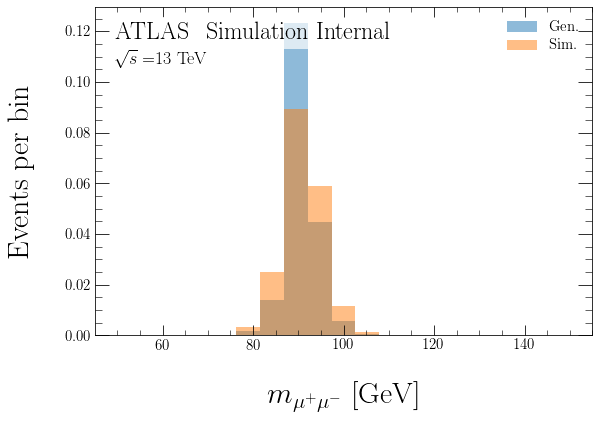

In [16]:
plt.figure()
hG, _, _ = plt.hist(Events_0.events['truth_m_ll'][mypass_0],
                    label="Gen.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)
hS, _, _ = plt.hist(Events_0.events['m_ll'][mypass_0],
                    label="Sim.",
                    bins=np.linspace(50, 150, 20),
#                     weights=weightsMC_0[mypass_0],
                    alpha=0.5, density=True)

plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
plt.ylabel("Events per bin")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

# plt.figure()
# hG, _, _ = plt.hist(Events_unknown.events['truth_m_ll'][mypass_unknown],
#                     label="Gen.",
#                     bins=np.linspace(50, 150, 20),
# #                     weights=weightsMC_unknown[mypass_unknown],
#                     alpha=0.5, density=True)
# hS, _, _ = plt.hist(Events_unknown.events['m_ll'][mypass_unknown],
#                     label="Sim.",
#                     bins=np.linspace(50, 150, 20),
# #                     weights=weightsMC_unknown[mypass_unknown],
#                     alpha=0.5, density=True)

# plt.xlabel("$m_{\mu^+\mu^-}$ [GeV]")
# plt.ylabel("Events per bin")
# draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
# plt.legend()
# # plt.ylim([0, 1.5 * max(max(hG), max(hS))])
# plt.show()

In [17]:
mytracks_0 = Events_0.events['truth_pT_Tracks'][mypass_0]
ntrack_0_Gen = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [18]:
mytracks_0 = Events_0.events['pT_Tracks'][mypass_0]
ntrack_0_Sim = [len(mytracks_0[i]) for i in range(len(mytracks_0))]

In [19]:
# mytracks_unknown = Events_unknown.events['truth_pT_Tracks'][mypass_unknown]
# ntrack_unknown_Gen = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

In [20]:
# mytracks_unknown = Events_unknown.events['pT_Tracks'][mypass_unknown]
# ntrack_unknown_Sim = [len(mytracks_unknown[i]) for i in range(len(mytracks_unknown))]

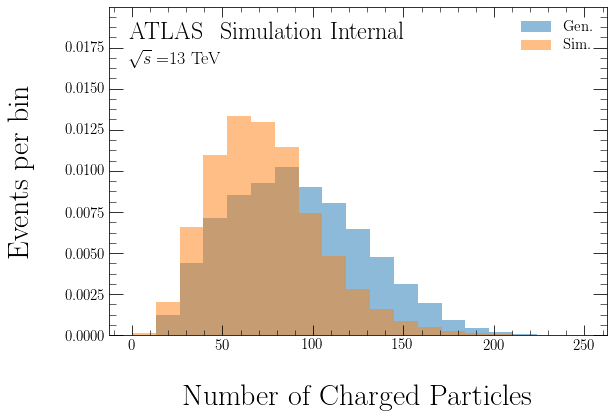

In [21]:
hG, _, _ = plt.hist(ntrack_0_Gen,
#                     weights=weightsMC_0[mypass_0],
                    label="Gen.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
hS, _, _ = plt.hist(ntrack_0_Sim,
#                     weights=weightsMC_0[mypass_0],
                    label="Sim.",
                    alpha=0.5,
                    density=True,
                    bins=np.linspace(0, 250, 20))
plt.xlabel("Number of Charged Particles")
draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
plt.ylabel("Events per bin")
plt.legend()
plt.ylim([0, 1.5 * max(max(hG), max(hS))])
plt.show()

# hG, _, _ = plt.hist(ntrack_unknown_Gen,
# #                     weights=weightsMC_unknown[mypass_unknown],
#                     label="Gen.",
#                     alpha=0.5,
#                     density=True,
#                     bins=np.linspace(0, 250, 20))
# hS, _, _ = plt.hist(ntrack_unknown_Sim,
# #                     weights=weightsMC_unknown[mypass_unknown],
#                     label="Sim.",
#                     alpha=0.5,
#                     density=True,
#                     bins=np.linspace(0, 250, 20))
# plt.xlabel("Number of Charged Particles")
# draw_atlas_text(lines=[r'$\sqrt{s} = $13 TeV'])
# plt.ylabel("Events per bin")
# plt.legend()
# plt.ylim([0, 1.5 * max(max(hG), max(hS))])
# plt.show()

# Stress Weights are Nonrandom 

For each observable $x$ in the "unknown" sample, the weight is given roughly by $w \propto x^n$ for some $n$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [22]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)
                                                                    
# m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
# m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

In [23]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))

In [24]:
weights_m_ll_stress = -np.min(weight_m_ll_seed) + weight_m_ll_seed
weights_m_ll_stress = (weights_m_ll_stress)**2
weights_m_ll_stress = weights_m_ll_stress/np.mean(weights_m_ll_stress)
# weights_m_ll_stress = np.array(weights_m_ll_stress)

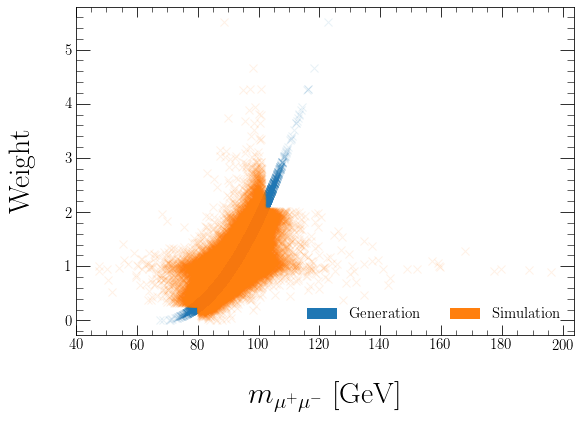

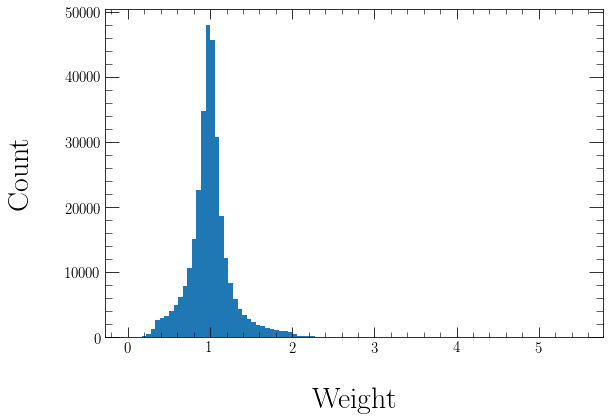

In [25]:
plt.figure()
plt.plot(m_ll_unknown_G, weights_m_ll_stress, 'x', alpha=0.1, label = 'Generation')
plt.plot(m_ll_unknown_S, weights_m_ll_stress, 'x', alpha=0.1, label = 'Simulation')
plt.xlabel('$m_{\mu^+\mu^-}$ [GeV]')
plt.ylabel('Weight')
handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
plt.legend(handles, labels, ncol=2)
plt.show()

plt.figure()
plt.hist(weights_m_ll_stress,
         bins=np.linspace(np.min(weights_m_ll_stress),
                          np.max(weights_m_ll_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

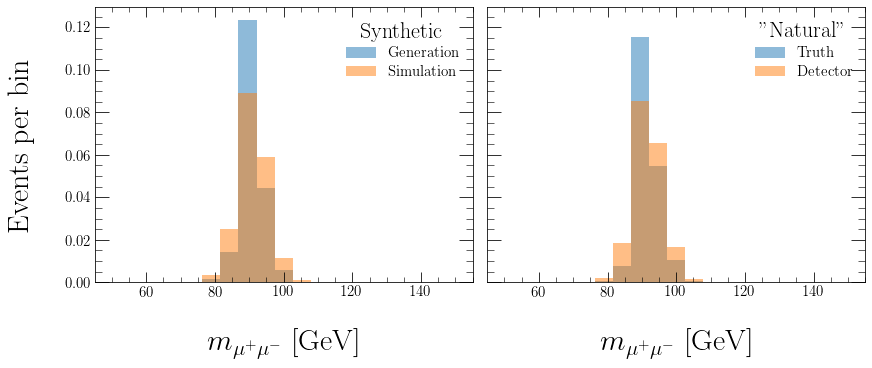

In [26]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, 
                       label='Generation', 
                       **plot_style_2)
hS0, _, _ = ax[0].hist(m_ll_0_S, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, label='Simulation', 
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, 
                       weights=weights_m_ll_stress, 
                       bins=bins,
                       label='Truth', 
                       **plot_style_2)
hS1, _, _ = ax[1].hist(m_ll_unknown_S, 
                       weights=weights_m_ll_stress, 
                       bins=bins, 
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [27]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(np.array(ntrack_0_Gen),
                                                                      np.array(ntrack_0_Sim), 
                                                                      test_size=0.5)

In [28]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

In [29]:
weights_nTracks_stress = -np.min(weight_nTracks_seed) + weight_nTracks_seed
weights_nTracks_stress = (weights_nTracks_stress)**2
weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)
# weights_nTracks_stress = np.array(weights_nTracks_stress)

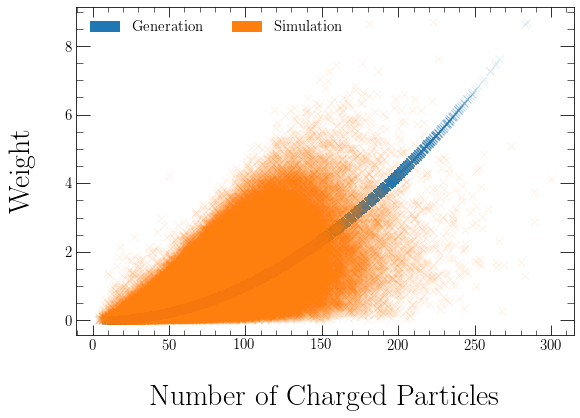

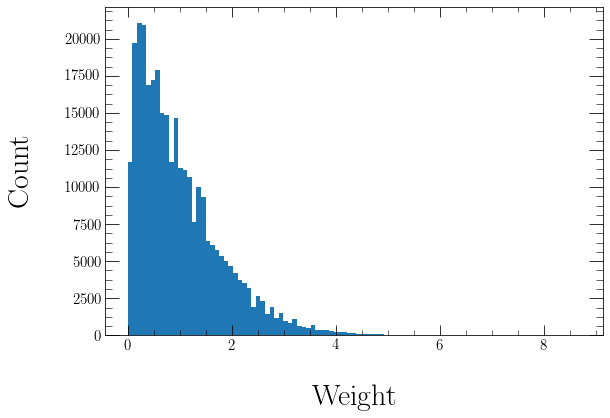

In [30]:
plt.figure()
plt.plot(nTracks_unknown_G, weights_nTracks_stress, 'x', alpha=0.1, label = 'Generation')
plt.plot(nTracks_unknown_S, weights_nTracks_stress, 'x', alpha=0.1, label = 'Simulation')
plt.xlabel('Number of Charged Particles')
plt.ylabel('Weight')
handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
plt.legend(handles, labels, ncol=2)
plt.show()

plt.figure()
plt.hist(weights_nTracks_stress,
         bins=np.linspace(np.min(weights_nTracks_stress),
                          np.max(weights_nTracks_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

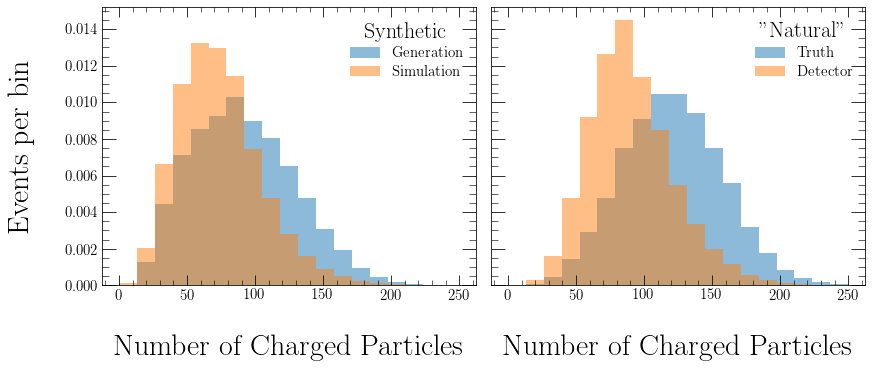

In [31]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Generation',
                       **plot_style_2)
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Simulation',
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2)
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define UniFold Algorithm

In [32]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        theta_0_G: synthetic generation-level observable as Numpy array
                    
        theta_0_S: synthetic simulation-level observable as Numpy array
                    
        theta_unknown_S: "natural" (unknown) simulation-level observable 
                            to be unfolded as Numpy arrays
                            
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            theta_0_G,
            theta_0_S,
            theta_unknown_S,
            weightsMC_0=None,
            weightsMC_unknown=None):
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$

In [33]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [34]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_m_ll_stress)





ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 466582 samples, validate on 155528 samples
Epoch 1/200





466582/466582 [==============================] - 2s 4us/step - loss: 0.6894 - acc: 0.5008 - val_loss: 0.6896 - val_acc: 0.5007
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5007 - val_loss: 0.6896 - val_acc: 0.5006
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5007 - val_loss: 0.6897 - val_acc: 0.5001
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5006 - val_loss: 0.6896 - val_acc: 0.5005
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5009 - val_loss: 0.6896 - val_acc: 0.5006
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6888 - acc: 0.5004 - val_loss: 0.6896 - 

466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5007 - val_loss: 0.6894 - val_acc: 0.5007
Epoch 36/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5008 - val_loss: 0.6893 - val_acc: 0.5003
Epoch 37/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5006 - val_loss: 0.6894 - val_acc: 0.5002
Epoch 38/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5008 - val_loss: 0.6893 - val_acc: 0.5003
Epoch 39/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5005 - val_loss: 0.6893 - val_acc: 0.5007
Epoch 40/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5004 - val_loss: 0.6893 - val_acc: 0.5007
Epoch 41/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6885 - acc: 0.5003 - val_loss: 0.6894 - val_acc: 0.5001
Epoch 42/200
466582/466582 [=====

466582/466582 [==============================] - 2s 5us/step - loss: 0.6877 - acc: 0.4996 - val_loss: 0.6875 - val_acc: 0.5014
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4993 - val_loss: 0.6874 - val_acc: 0.5016
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4998 - val_loss: 0.6875 - val_acc: 0.5012
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4993 - val_loss: 0.6874 - val_acc: 0.5015
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4995 - val_loss: 0.6875 - val_acc: 0.5016
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4993 - val_loss: 0.6875 - val_acc: 0.5014
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6876 - acc: 0.4996 - val_loss: 0.6875 - val_acc: 0.5015
Epoch 8/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6945 - acc: 0.5006 - val_loss: 0.6956 - val_acc: 0.5008
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6945 - acc: 0.5001 - val_loss: 0.6956 - val_acc: 0.5020
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6945 - acc: 0.4996 - val_loss: 0.6956 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6868 - acc: 0.4998 - val_loss: 0.6858 - val_acc: 0.4992
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6853 - acc: 0.5001 - val_loss: 0.6858 - val_acc: 0.4995
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6853 - acc: 0.5000 - val_loss: 0.6858 - val_acc: 0.4996
Epoch 4/200
466582/466582 [=====


STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6833 - acc: 0.5003 - val_loss: 0.6815 - val_acc: 0.4994
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5002 - val_loss: 0.6814 - val_acc: 0.4994
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5004 - val_loss: 0.6813 - val_acc: 0.4994
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5006 - val_loss: 0.6813 - val_acc: 0.4994
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5003 - val_loss: 0.6813 - val_acc: 0.4984
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5000 - val_loss: 0.6813 - val_acc: 0.4987
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6809 - acc: 0.5001 - v

466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5000 - val_loss: 0.6904 - val_acc: 0.4997
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5011 - val_loss: 0.6904 - val_acc: 0.5010
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5007 - val_loss: 0.6905 - val_acc: 0.4999
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5009 - val_loss: 0.6904 - val_acc: 0.4993
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5008 - val_loss: 0.6905 - val_acc: 0.4992
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5006 - val_loss: 0.6905 - val_acc: 0.4996
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6914 - acc: 0.5005 - val_loss: 0.6905 - val_acc: 0.4991
Epoch 13/200
466582/466582 [========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6832 - acc: 0.4997 - val_loss: 0.6832 - val_acc: 0.5002
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6832 - acc: 0.4996 - val_loss: 0.6832 - val_acc: 0.5003
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6832 - acc: 0.4998 - val_loss: 0.6831 - val_acc: 0.5001
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6832 - acc: 0.4998 - val_loss: 0.6831 - val_acc: 0.5001
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6832 - acc: 0.4998 - val_loss: 0.6832 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping

ITERATION: 10

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6979 - acc: 0.4999 - val_loss: 0.6954 - val_acc: 0.5002
Epoch 2/200
466

#### Step 1 Results (Simulation-level)

ITERATION 1:


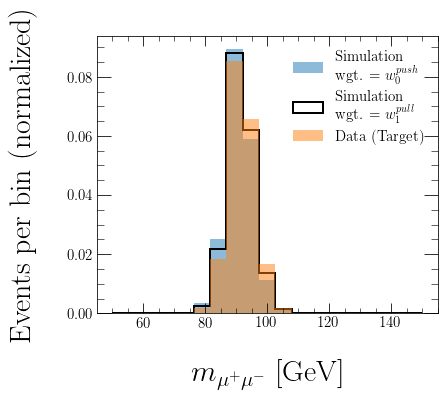

ITERATION 2:


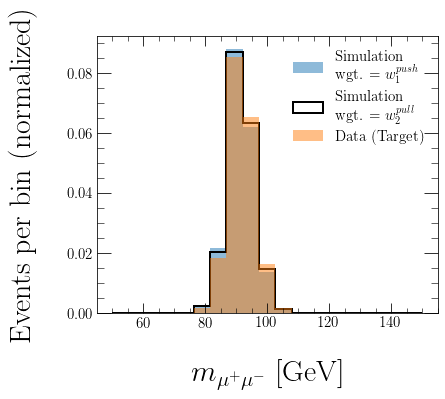

ITERATION 3:


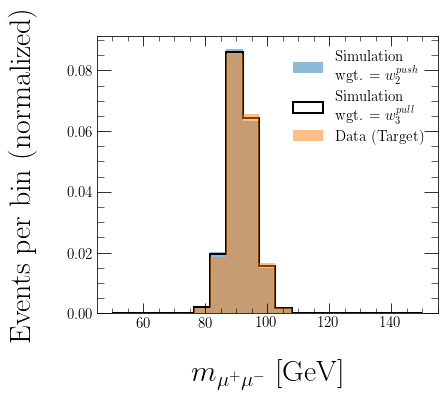

ITERATION 4:


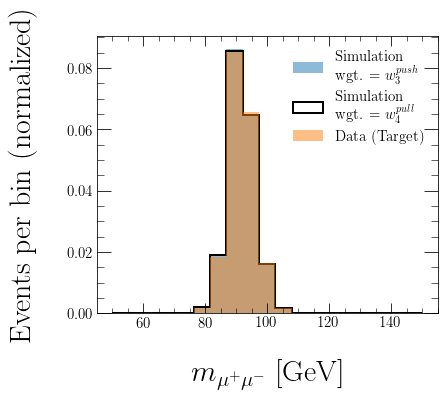

ITERATION 5:


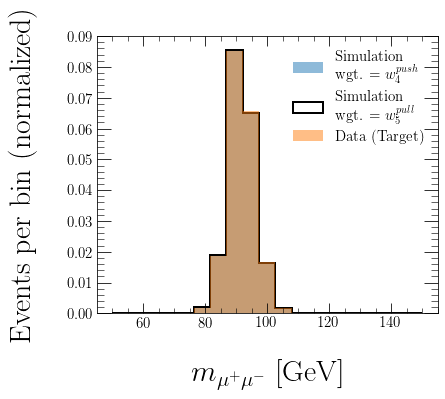

ITERATION 6:


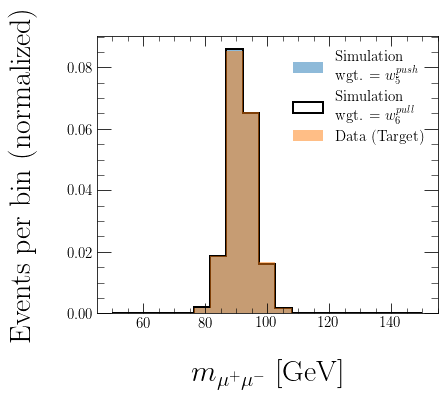

ITERATION 7:


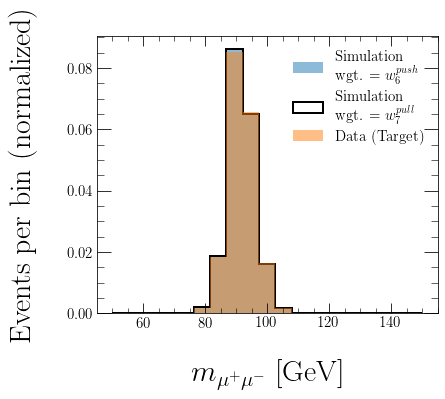

ITERATION 8:


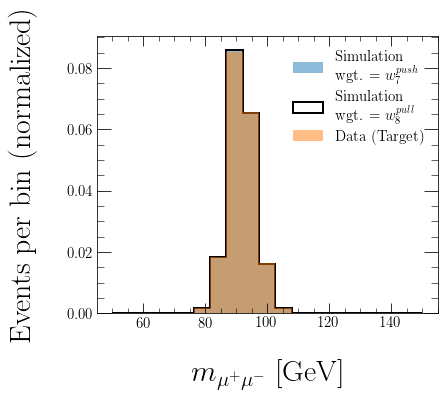

ITERATION 9:


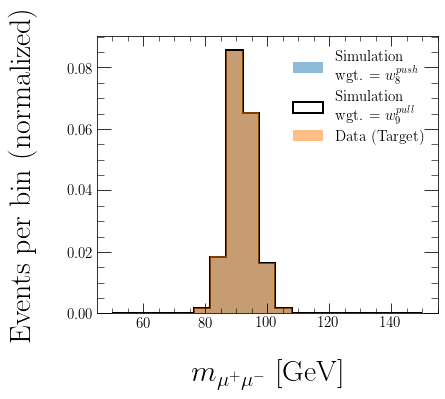

ITERATION 10:


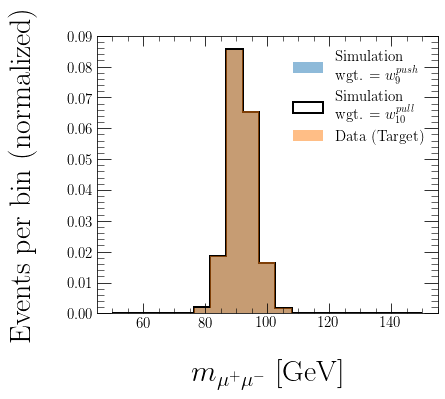

In [35]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        m_ll_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_S,
        weights=weights_m_ll_stress,
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


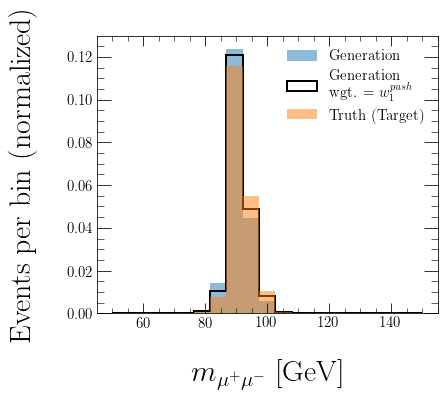

ITERATION 2:


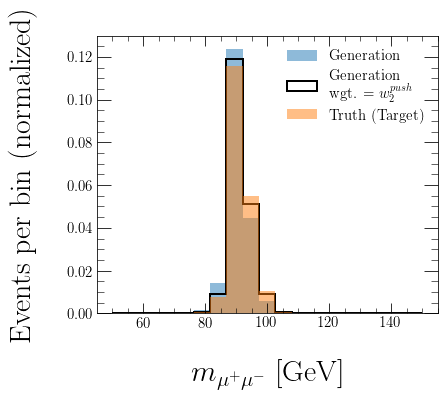

ITERATION 3:


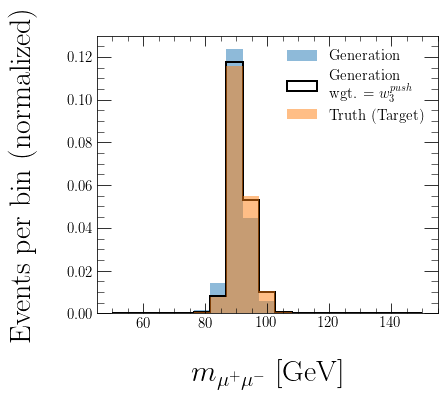

ITERATION 4:


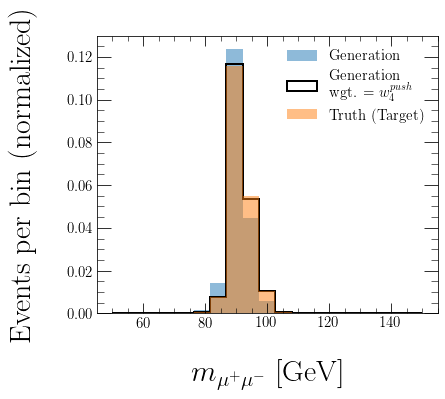

ITERATION 5:


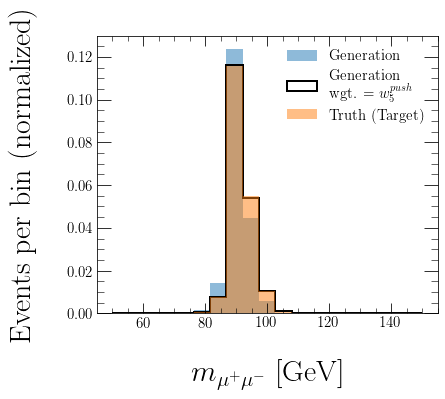

ITERATION 6:


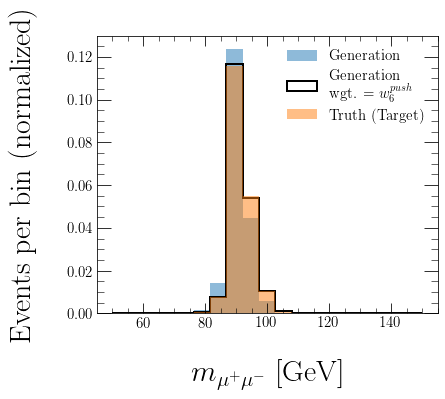

ITERATION 7:


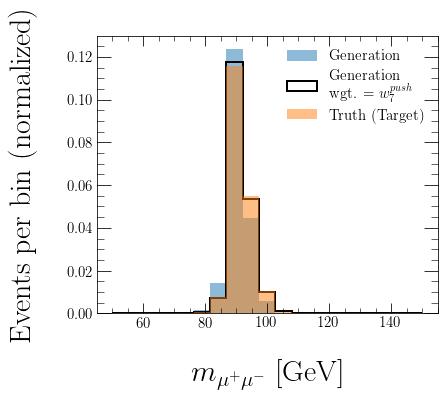

ITERATION 8:


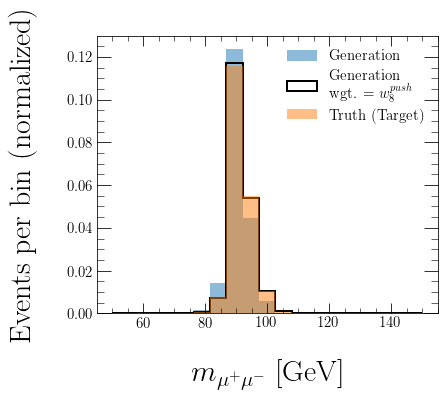

ITERATION 9:


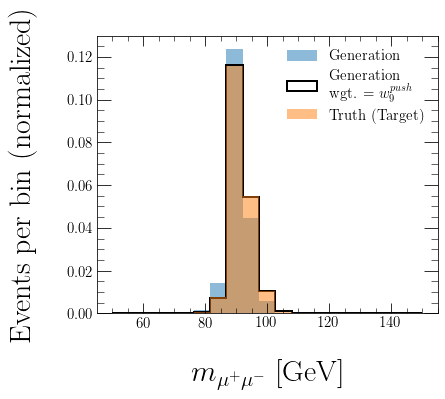

ITERATION 10:


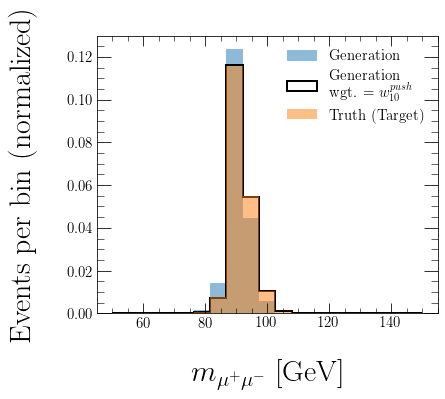

In [36]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_G,
        weights=weights_m_ll_stress,
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [37]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [38]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6611 - acc: 0.4990 - val_loss: 0.6505 - val_acc: 0.5025
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6508 - acc: 0.4992 - val_loss: 0.6499 - val_acc: 0.5019
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6505 - acc: 0.4991 - val_loss: 0.6497 - val_acc: 0.5019
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6504 - acc: 0.4992 - val_loss: 0.6497 - val_acc: 0.5019
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6504 - acc: 0.4991 - val_loss: 0.6496 - val_acc: 0.5019
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6503 - acc: 0.4992 - val_loss: 0.6495 - val_acc: 0.5018
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6503 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.4999 - val_loss: 0.6850 - val_acc: 0.4996
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.5000 - val_loss: 0.6850 - val_acc: 0.4998
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.5001 - val_loss: 0.6850 - val_acc: 0.4998
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.4997 - val_loss: 0.6850 - val_acc: 0.4997
Epoch 23/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.5000 - val_loss: 0.6850 - val_acc: 0.4996
Epoch 24/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6856 - acc: 0.4999 - val_loss: 0.6850 - val_acc: 0.4999
Restoring model weights from the end of the best epoch
Epoch 00024: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==

466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5000 - val_loss: 0.6943 - val_acc: 0.5002
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5003 - val_loss: 0.6941 - val_acc: 0.5005
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5000 - val_loss: 0.6942 - val_acc: 0.5007
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.4998 - val_loss: 0.6941 - val_acc: 0.5002
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.4995 - val_loss: 0.6942 - val_acc: 0.5002
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.4999 - val_loss: 0.6941 - val_acc: 0.5005
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5000 - val_loss: 0.6942 - val_acc: 0.5003
Epoch 15/200
466582/466582 [======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5001 - val_loss: 0.6192 - val_acc: 0.4994
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5002 - val_loss: 0.6192 - val_acc: 0.4997
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5002 - val_loss: 0.6192 - val_acc: 0.4997
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5001 - val_loss: 0.6193 - val_acc: 0.4997
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5001 - val_loss: 0.6193 - val_acc: 0.4997
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5002 - val_loss: 0.6192 - val_acc: 0.4997
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6184 - acc: 0.5001 - val_loss: 0.6193 - val_acc: 0.4994
Epoch 13/200
466582/466582 [========

466582/466582 [==============================] - 1s 2us/step - loss: 0.6165 - acc: 0.5002 - val_loss: 0.6153 - val_acc: 0.4995
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6166 - acc: 0.5002 - val_loss: 0.6153 - val_acc: 0.4995
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6166 - acc: 0.5001 - val_loss: 0.6153 - val_acc: 0.4996
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6165 - acc: 0.5001 - val_loss: 0.6153 - val_acc: 0.4996
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6165 - acc: 0.5000 - val_loss: 0.6153 - val_acc: 0.5001
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6166 - acc: 0.5000 - val_loss: 0.6153 - val_acc: 0.4996
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6166 - acc: 0.5001 - val_loss: 0.6153 - val_acc: 0.4995
Epoch 14/200
466582/466582 [=======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6918 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4989
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6917 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6917 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6917 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.4990
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6917 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6916 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6917 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.4999
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6162 - acc: 0.4999 - val_loss: 0.6153 - val_acc: 0.5003
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6162 - acc: 0.4999 - val_loss: 0.6152 - val_acc: 0.5004
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6162 - acc: 0.4998 - val_loss: 0.6153 - val_acc: 0.5003
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6162 - acc: 0.5000 - val_loss: 0.6153 - val_acc: 0.5004
Epoch 9/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6162 - acc: 0.4999 - val_loss: 0.6152 - val_acc: 0.5004
Epoch 10/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6162 - acc: 0.4999 - val_loss: 0.6153 - val_acc: 0.5004
Epoch 11/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6162 - acc: 0.4998 - val_loss: 0.6152 - val_acc: 0.5004
Epoch 12/200
466582/466582 [=========

#### Step 1 Results (Simulation-level)

ITERATION 1:


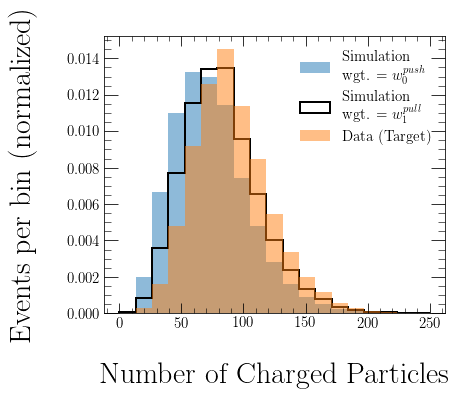

ITERATION 2:


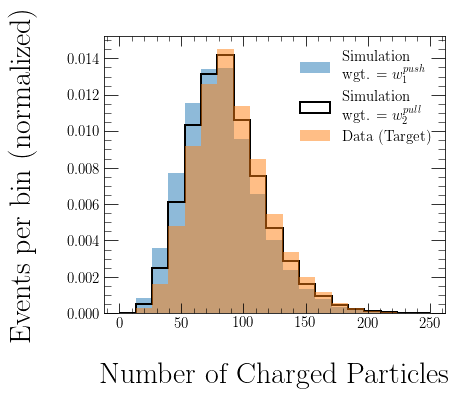

ITERATION 3:


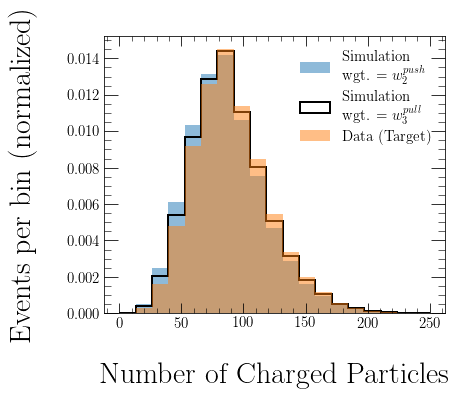

ITERATION 4:


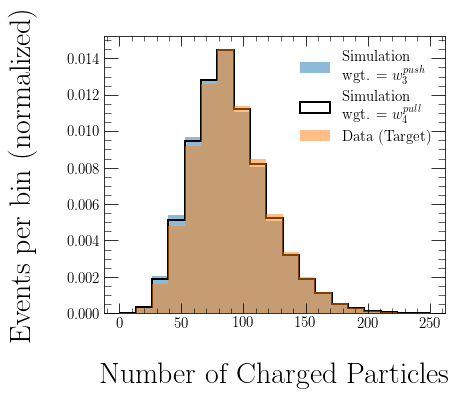

ITERATION 5:


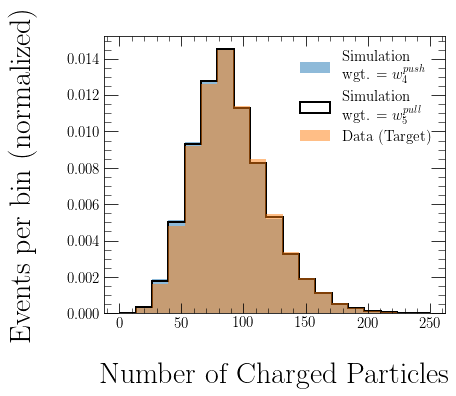

ITERATION 6:


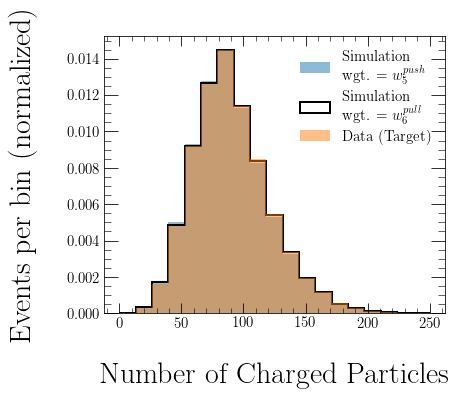

ITERATION 7:


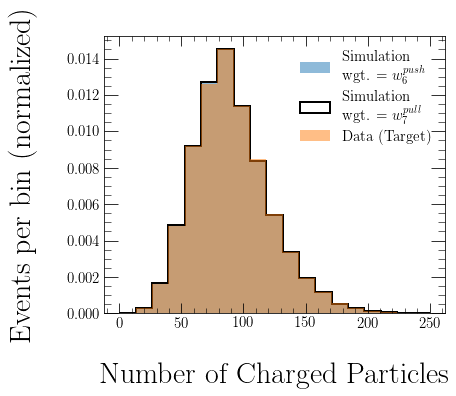

ITERATION 8:


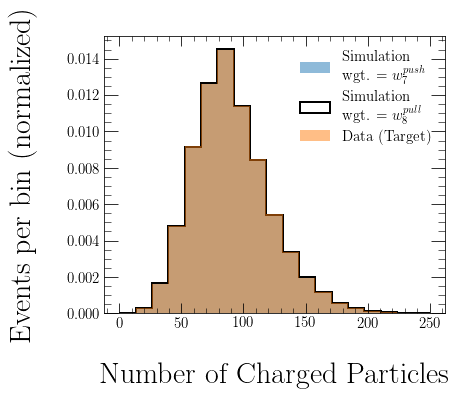

ITERATION 9:


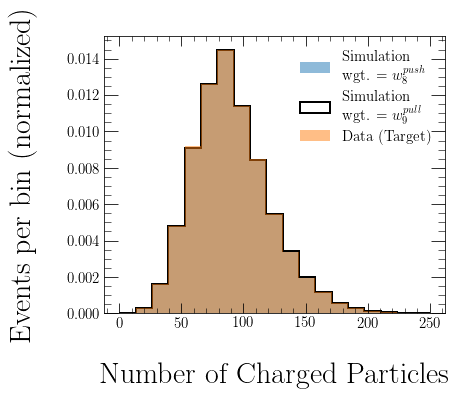

ITERATION 10:


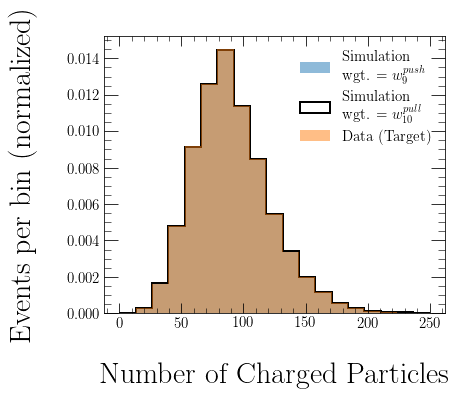

In [39]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        nTracks_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_S,
        weights=weights_nTracks_stress,
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


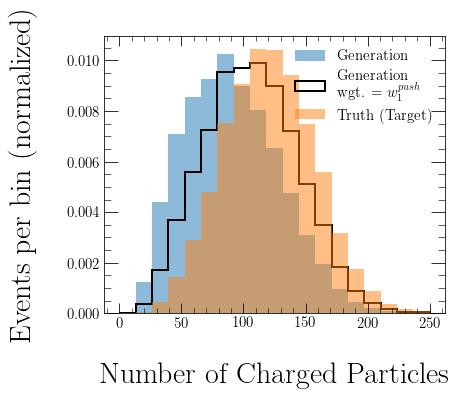

ITERATION 2:


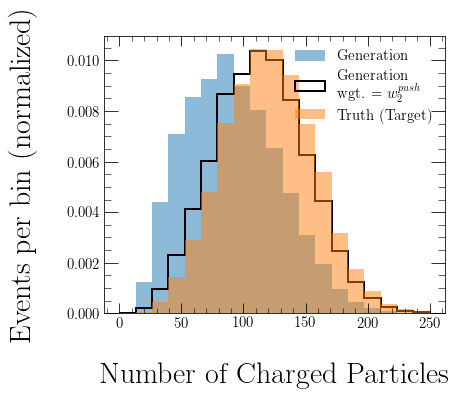

ITERATION 3:


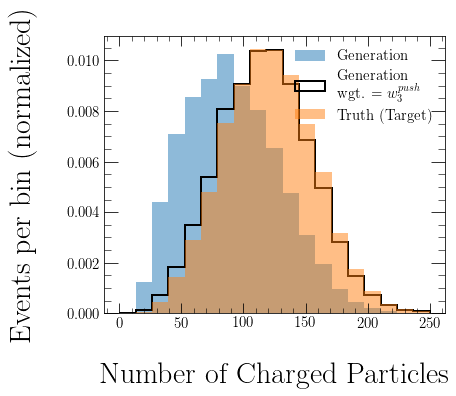

ITERATION 4:


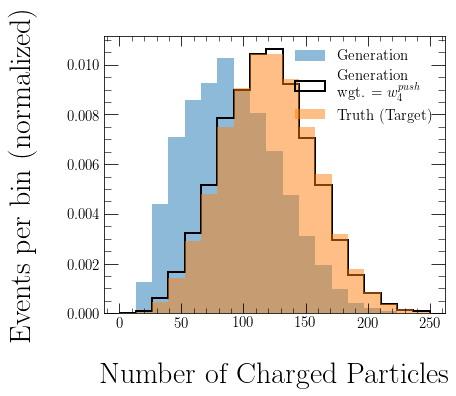

ITERATION 5:


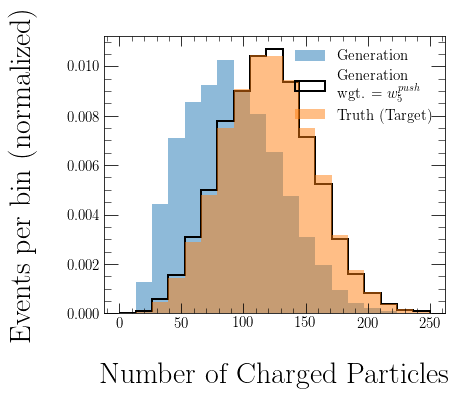

ITERATION 6:


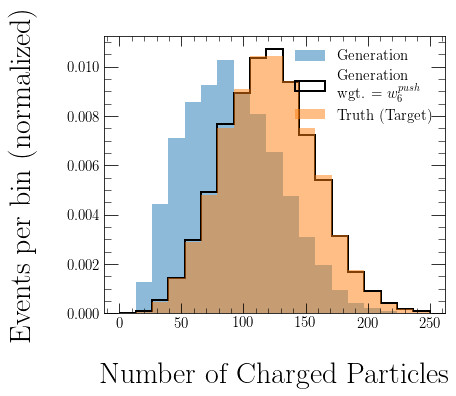

ITERATION 7:


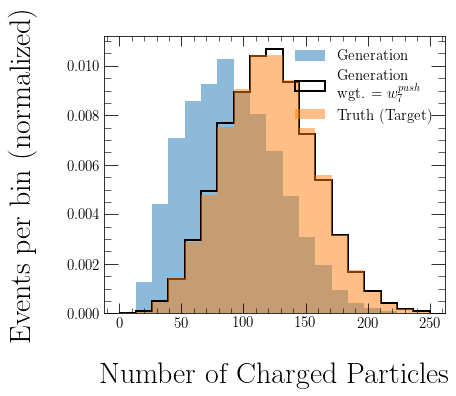

ITERATION 8:


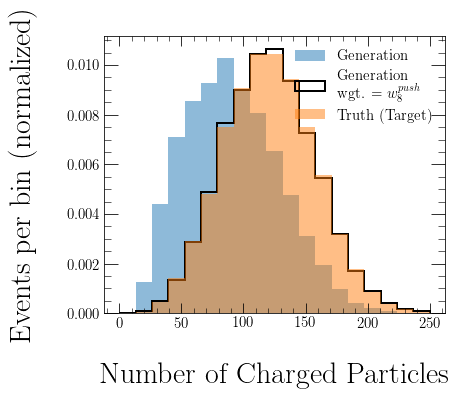

ITERATION 9:


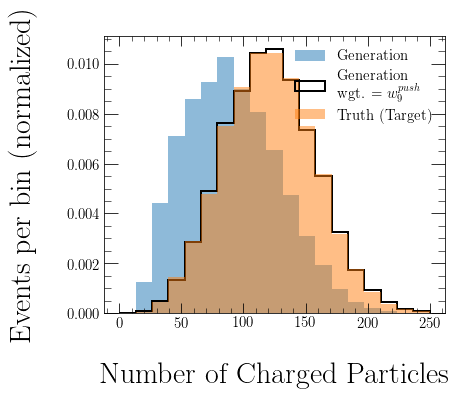

ITERATION 10:


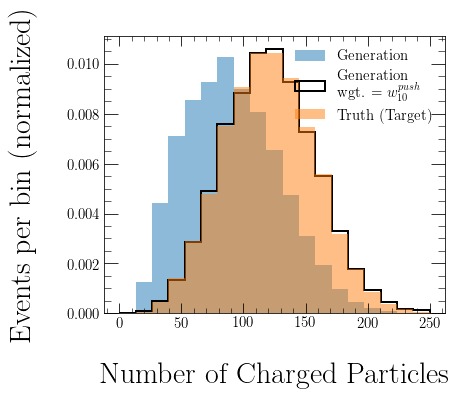

In [40]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_G,
        weights=weights_nTracks_stress,
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [41]:
K.clear_session()

### Setup datasets

In [42]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_0_Gen),
    np.array(ntrack_0_Sim),
    test_size=0.5)

In [43]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [44]:
weights_stress = -np.min(weight_seed) + weight_seed
weights_stress = (weights_stress)**3
weights_stress = weights_stress/np.mean(weights_stress)
# weights_stress = np.array(weights_stress)

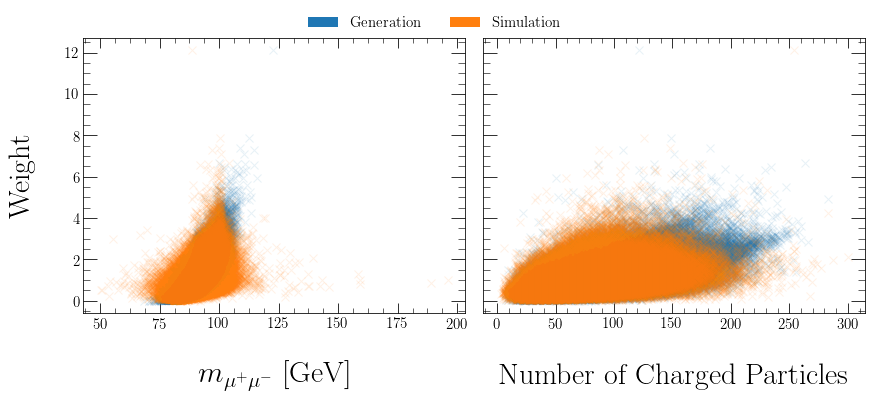

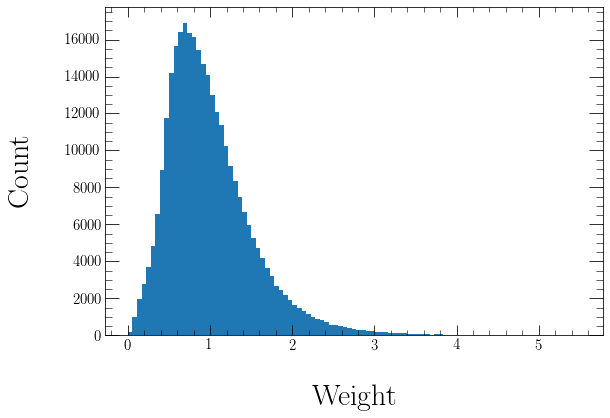

In [45]:
fig, ax = plt.subplots(1,2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey='row')

ax[0].plot(m_ll_unknown_G, weights_stress, 'x', alpha=0.1, label = 'Generation')
ax[0].plot(m_ll_unknown_S, weights_stress, 'x', alpha=0.1, label = 'Simulation')
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Weight')

ax[1].plot(nTracks_unknown_G, weights_stress, 'x', alpha=0.1, label = 'Generation')
ax[1].plot(nTracks_unknown_S, weights_stress, 'x', alpha=0.1, label = 'Simulation')
ax[1].set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.665, 1.1))
fig.show()

plt.figure()
plt.hist(weights_stress,
         bins=np.linspace(np.min(weights_m_ll_stress),
                          np.max(weights_m_ll_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

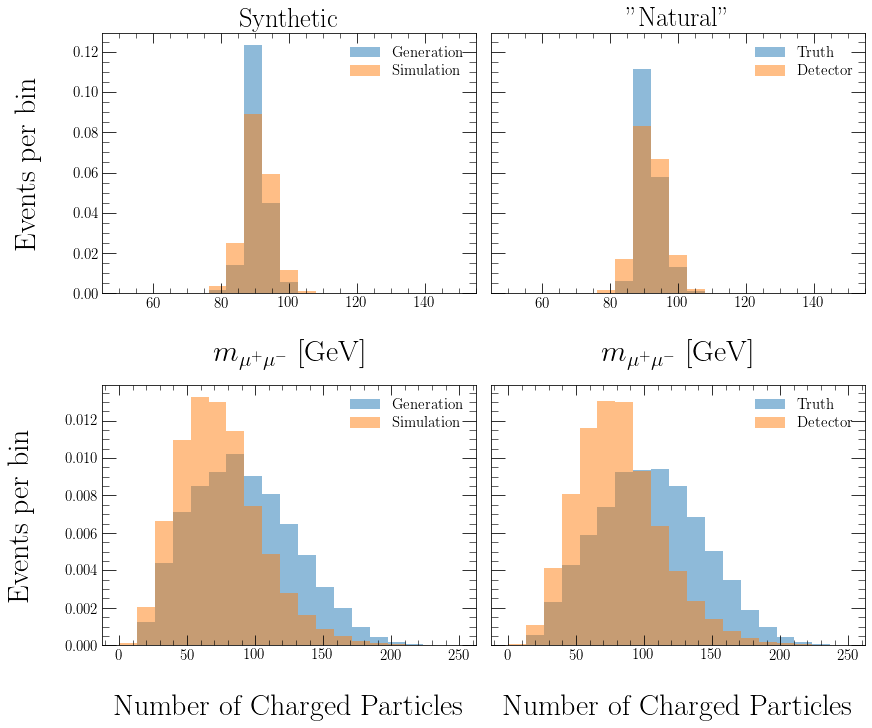

In [46]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(m_ll_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[0, 0].hist(m_ll_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(nTracks_0_G,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Generation',
                          **plot_style_2)
hS0, _, _ = ax[1, 0].hist(nTracks_0_S,
#                           weights=weightsMC_0[mypass_0],
                          bins=bins,
                          label='Simulation',
                          **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Define MultiFold Algorithm

In [47]:
# Input multiple observables as tuple or list (i.e. theta_0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta_0_G: tuple or list of synthetic 
                    generation-level observables as Numpy arrays
                    
        theta_0_S: tuple or list of synthetic 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        weightsMC_0: (optional) initial MC generator weights for synthetic sample
        
        weightsMC_unknown: (optional) initial MC generator weights for natural sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    theta_0_G to the unfolded distribution of theta_unknown_S
        
        model: The model used to calculate those weights
"""


def multifold(num_observables,
              iterations,
              theta_0_G,
              theta_0_S,
              theta_unknown_S,
              weightsMC_0=None,
              weightsMC_unknown=None):

    theta_0_G = np.stack(theta_0_G, axis=1)
    theta_0_S = np.stack(theta_0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)
    
    if weightsMC_0 is None:
        weightsMC_0 = np.ones(len(theta_0_G)) 
        
    if weightsMC_unknown is None:
        weightsMC_unknown = np.ones(len(theta_unknown_S))

    labels_0 = np.zeros(len(theta_0_G))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta_0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((theta_0_G, theta_0_G))
    yvals_2 = np.concatenate((labels_0, (labels_0+1.)))

    weights = np.empty(shape=(iterations, 2, len(theta_0_G)))
    # shape = (iteration, step, event)

    weights_pull = weightsMC_0
    weights_push = weightsMC_0

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, weightsMC_unknown))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, theta_0_S)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((weightsMC_0, weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = weightsMC_0 * reweight(model, theta_0_G)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [48]:
num_observables = 2

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [49]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
#                        weightsMC_0=weightsMC_0[mypass_0],
                       theta_unknown_S=theta_unknown_S,
                       weightsMC_unknown=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6804 - acc: 0.4987 - val_loss: 0.6783 - val_acc: 0.5003
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6774 - acc: 0.4986 - val_loss: 0.6782 - val_acc: 0.5000
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6774 - acc: 0.4985 - val_loss: 0.6782 - val_acc: 0.4998
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6773 - acc: 0.4986 - val_loss: 0.6782 - val_acc: 0.5000
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6773 - acc: 0.4986 - val_loss: 0.6782 - val_acc: 0.5003
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6773 - acc: 0.4983 - val_loss: 0.6782 - val_acc: 0.4999
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6773 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.4998 - val_loss: 0.6836 - val_acc: 0.5005
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.4997 - val_loss: 0.6837 - val_acc: 0.5007
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.5000 - val_loss: 0.6837 - val_acc: 0.5006
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.4997 - val_loss: 0.6837 - val_acc: 0.5008
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.4999 - val_loss: 0.6837 - val_acc: 0.5005
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.4998 - val_loss: 0.6837 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping

ITERATION: 2

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582

466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5006 - val_loss: 0.6709 - val_acc: 0.4980
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5007 - val_loss: 0.6708 - val_acc: 0.4982
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5006 - val_loss: 0.6708 - val_acc: 0.4980
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5006 - val_loss: 0.6709 - val_acc: 0.4980
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5006 - val_loss: 0.6708 - val_acc: 0.4984
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6712 - acc: 0.5006 - val_loss: 0.6709 - val_acc: 0.4980
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6711 - acc: 0.5006 - val_loss: 0.6708 - val_acc: 0.4981
Epoch 17/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6643 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5007
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 5

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.7003 - acc: 0.4993 - val_loss: 0.6957 - val_acc: 0.4985
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6951 - acc: 0.4999 - val_loss: 0.6955 - val_acc: 0.4981
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6950 - acc: 0.5001 - val_loss: 0.6955 - val_acc: 0.4984
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6950 - acc: 0.5001 - val_loss: 0.6955 - val_acc: 0.4987
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6950 - acc: 0.5006 - val_loss: 0.6955 - val_acc: 0.5009
Epoch 6/200
466582/4

466582/466582 [==============================] - 1s 2us/step - loss: 0.6650 - acc: 0.5007 - val_loss: 0.6654 - val_acc: 0.4981
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6650 - acc: 0.5007 - val_loss: 0.6655 - val_acc: 0.4978
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6649 - acc: 0.5007 - val_loss: 0.6655 - val_acc: 0.4978
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6650 - acc: 0.5007 - val_loss: 0.6655 - val_acc: 0.4977
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6650 - acc: 0.5007 - val_loss: 0.6655 - val_acc: 0.4978
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6650 - acc: 0.5006 - val_loss: 0.6655 - val_acc: 0.4976
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6649 - acc: 0.5006 - val_loss: 0.6654 - val_acc: 0.4979
Epoch 14/200
466582/466582 [=======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6967 - acc: 0.5004 - val_loss: 0.6981 - val_acc: 0.5005
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6967 - acc: 0.5007 - val_loss: 0.6982 - val_acc: 0.5003
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6967 - acc: 0.5012 - val_loss: 0.6981 - val_acc: 0.5012
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 6us/step - loss: 0.6710 - acc: 0.5000 - val_loss: 0.6621 - val_acc: 0.5005
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6623 - acc: 0.4998 - val_loss: 0.6617 - val_acc: 0.5001
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6622 - acc: 0.5001 - val_loss: 0.6617 - val_acc: 0.5001
Epoch 4/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6897 - acc: 0.5011 - val_loss: 0.6904 - val_acc: 0.5007
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6898 - acc: 0.5014 - val_loss: 0.6904 - val_acc: 0.4997
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6726 - acc: 0.4990 - val_loss: 0.6638 - val_acc: 0.5015
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6641 - acc: 0.4994 - val_loss: 0.6638 - val_acc: 0.5015
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6641 - acc: 0.4994 - val_loss: 0.6639 - val_acc: 0.5014
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6641 - acc: 0.4994 - val_loss: 0.6638 - val_acc: 0.5014
Epoch 5/200
466582/466582 [======

#### Step 1 Results (Simulation-level)

ITERATION: 1


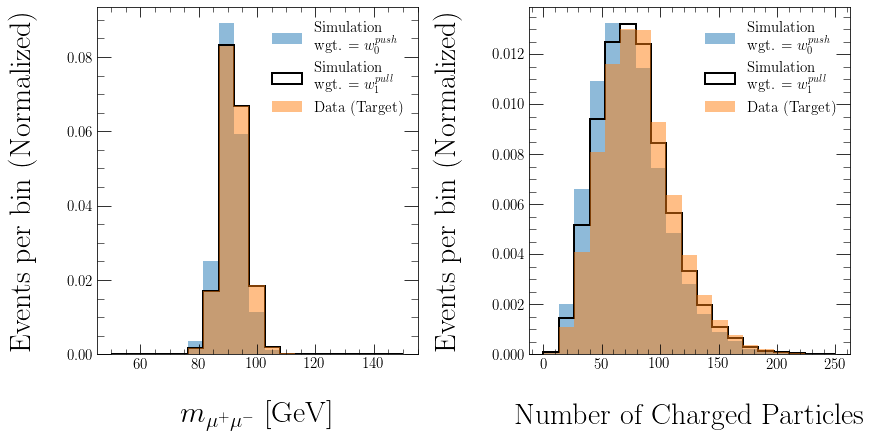

ITERATION: 2


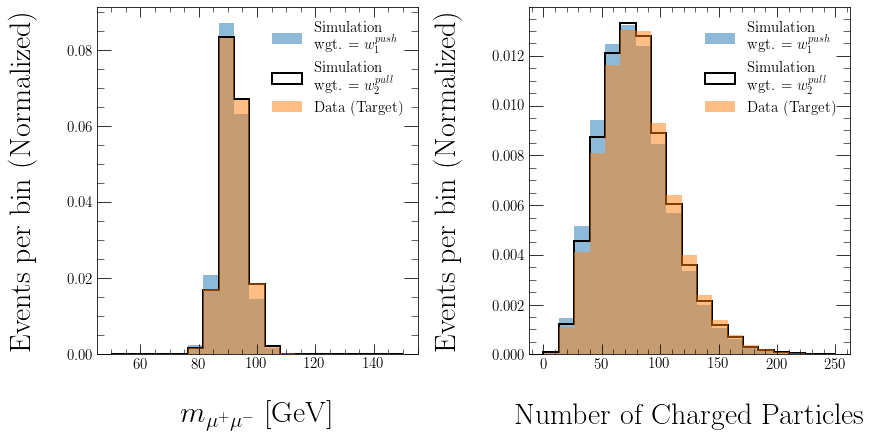

ITERATION: 3


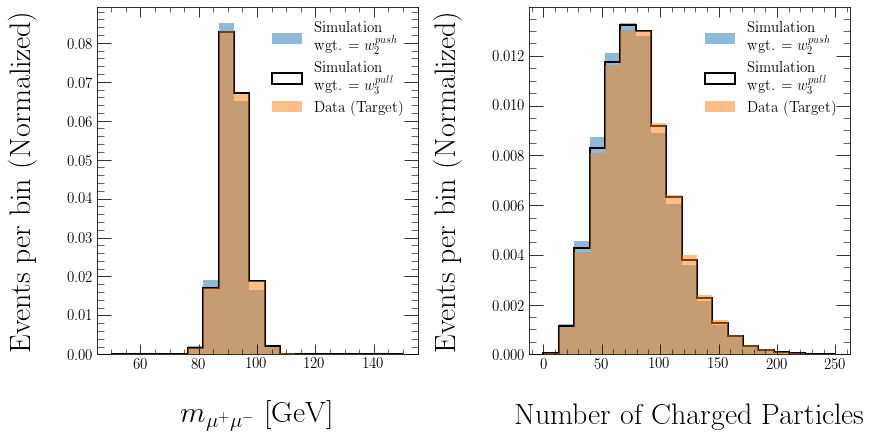

ITERATION: 4


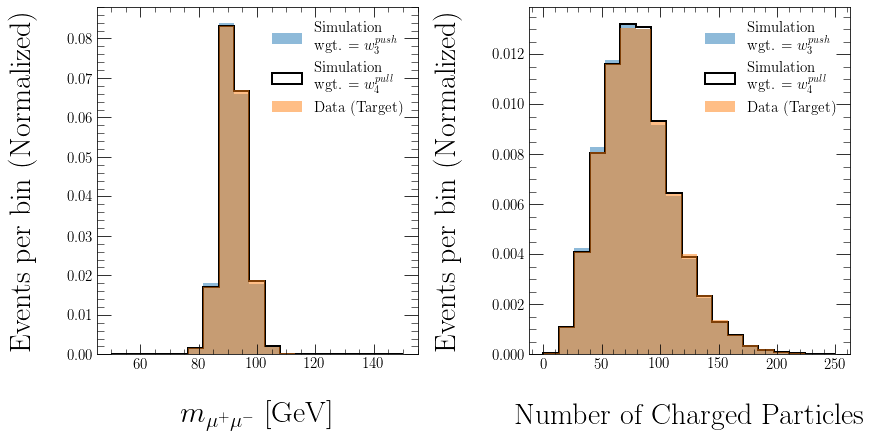

ITERATION: 5


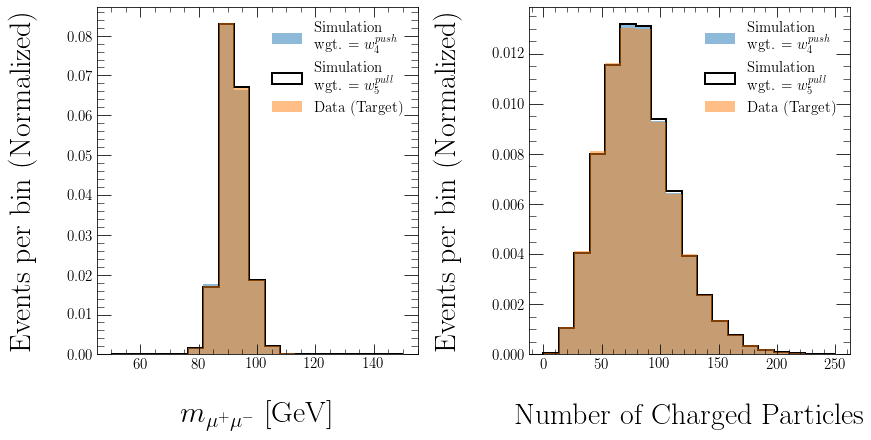

ITERATION: 6


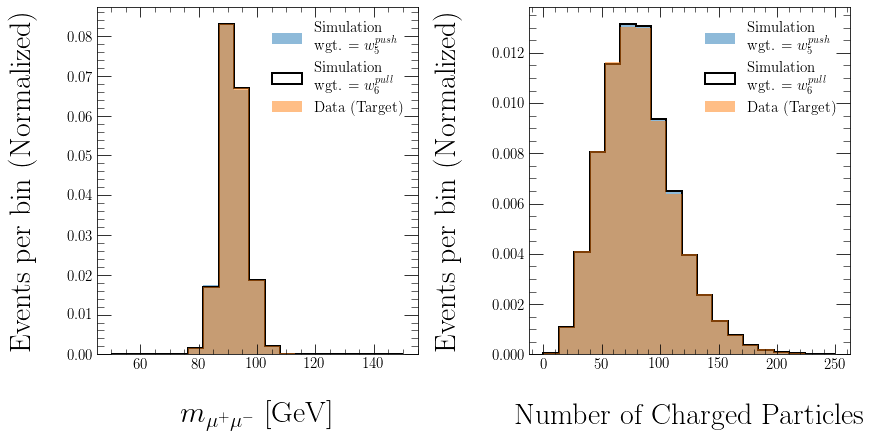

ITERATION: 7


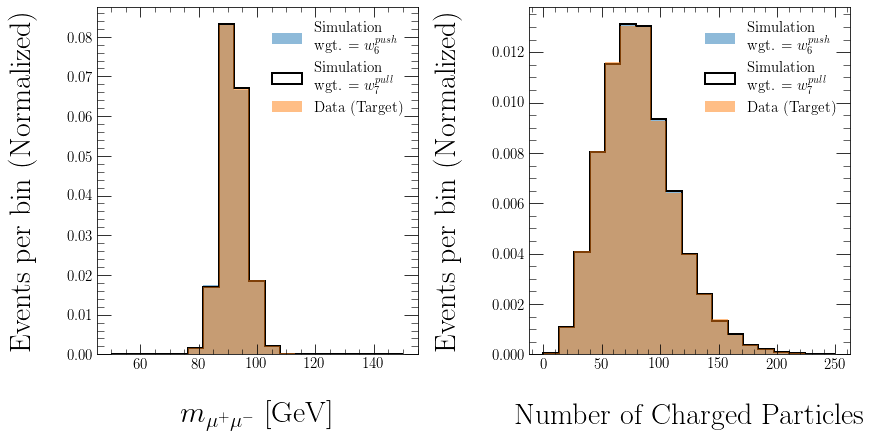

ITERATION: 8


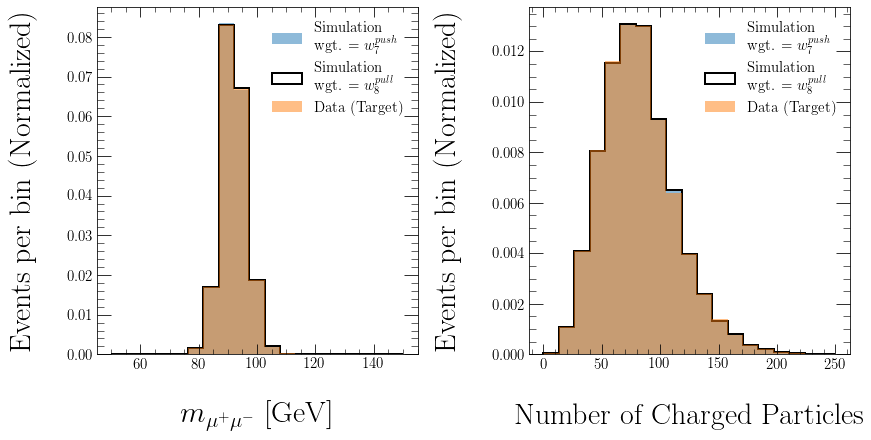

ITERATION: 9


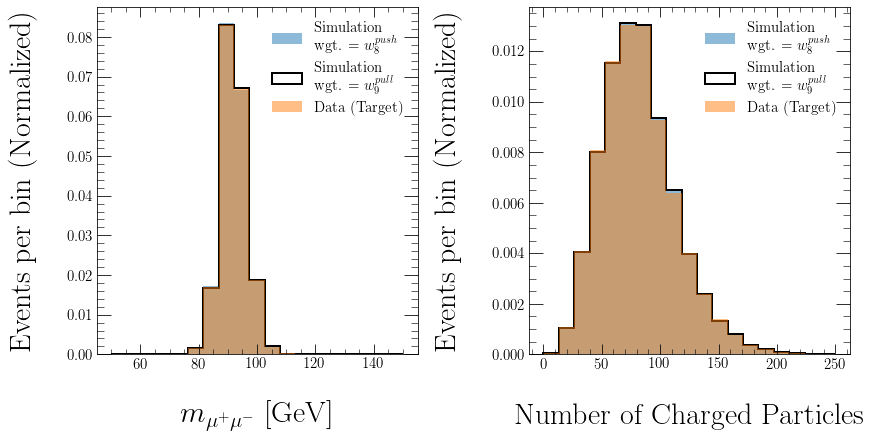

ITERATION: 10


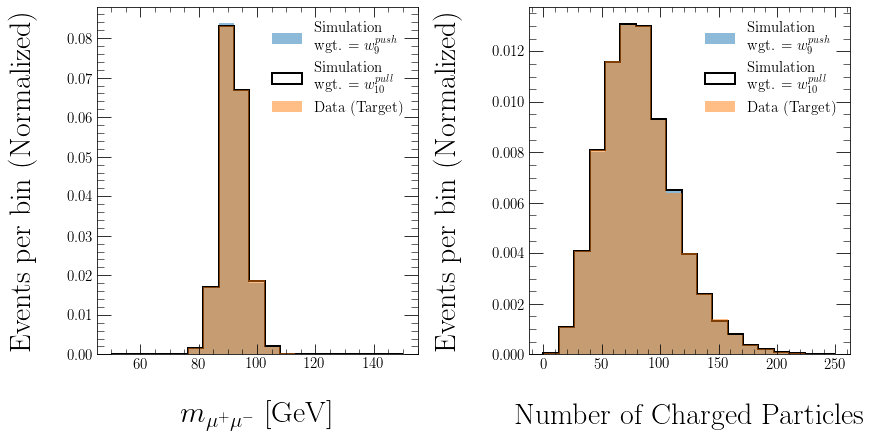

In [50]:
for i in range(len(weights)):

    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2)
    ax[0].hist(
        m_ll_0_S,
        bins=bins,
        weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0].hist(m_ll_unknown_S,
               weights=weights_stress,
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2)
    ax[1].hist(
        nTracks_0_S,
        bins=bins,
        weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1].hist(nTracks_unknown_S,
               weights=weights_stress,
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION: 1


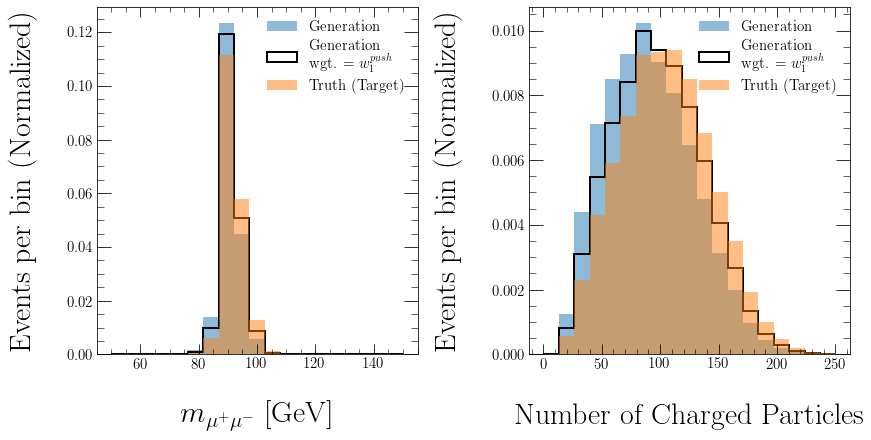

ITERATION: 2


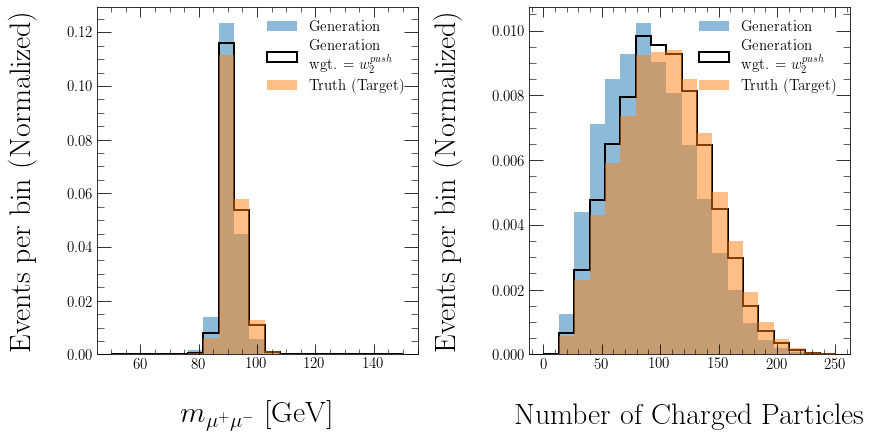

ITERATION: 3


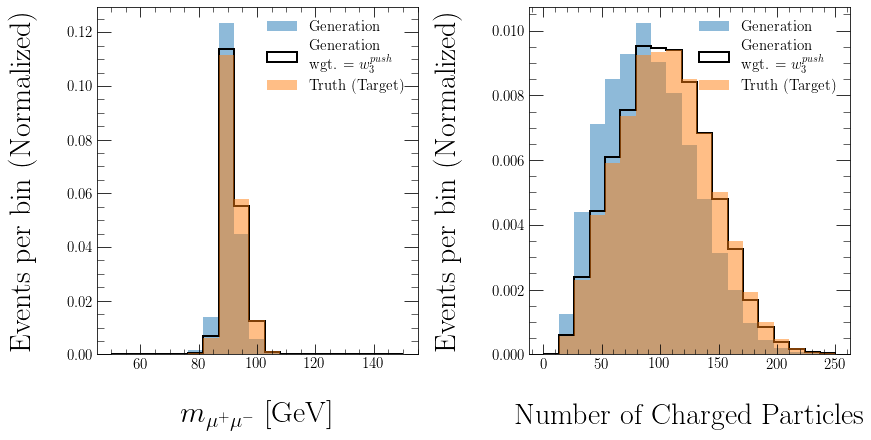

ITERATION: 4


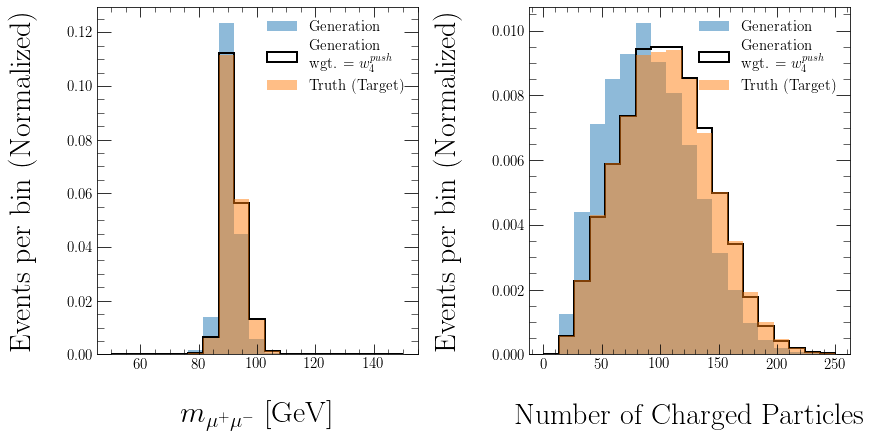

ITERATION: 5


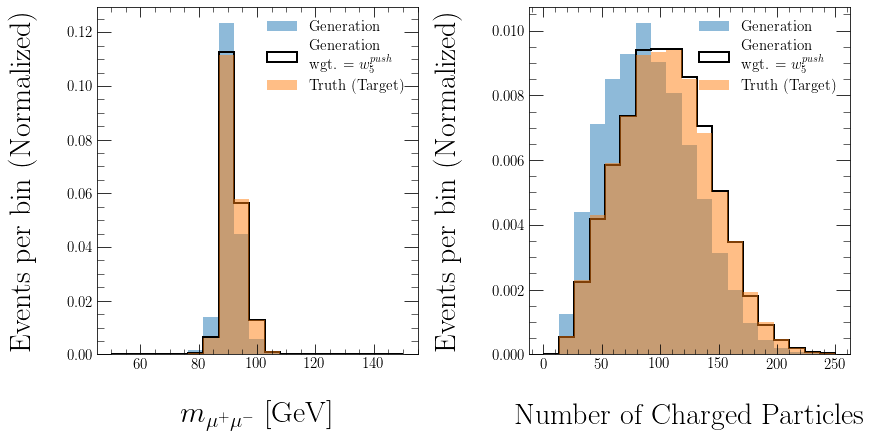

ITERATION: 6


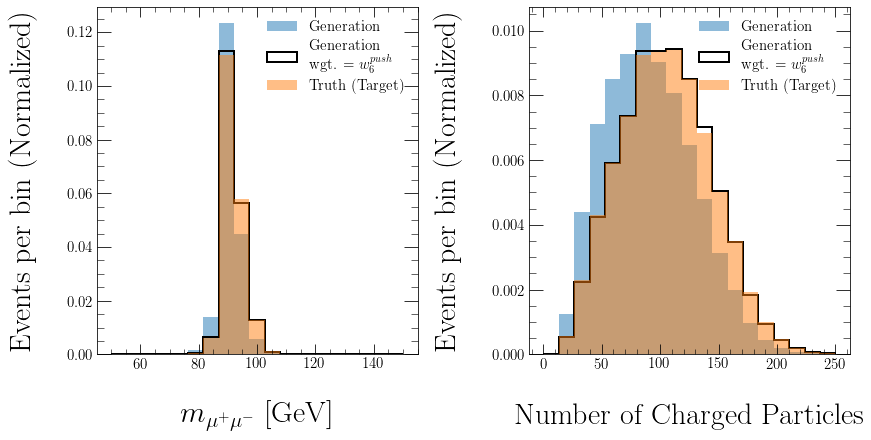

ITERATION: 7


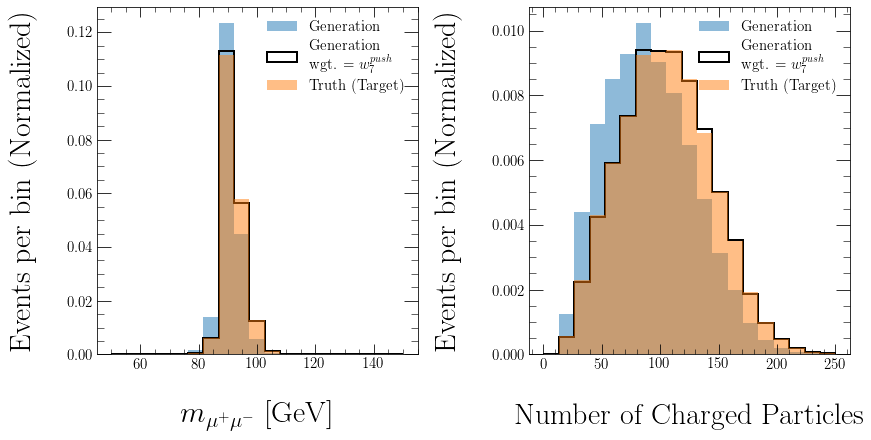

ITERATION: 8


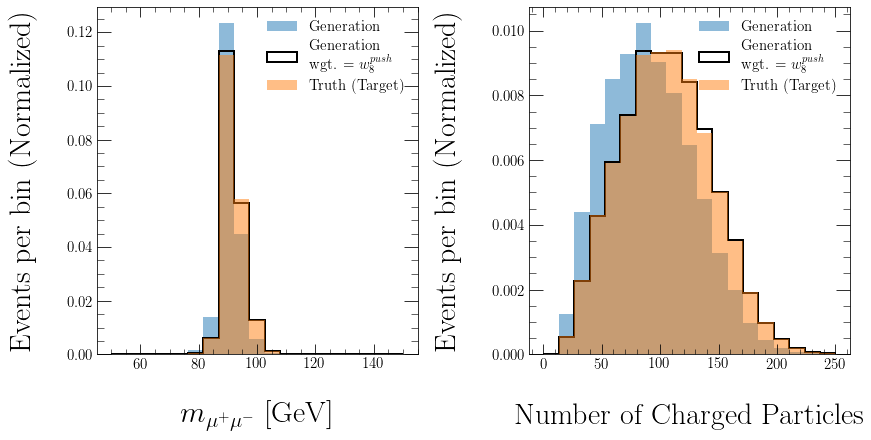

ITERATION: 9


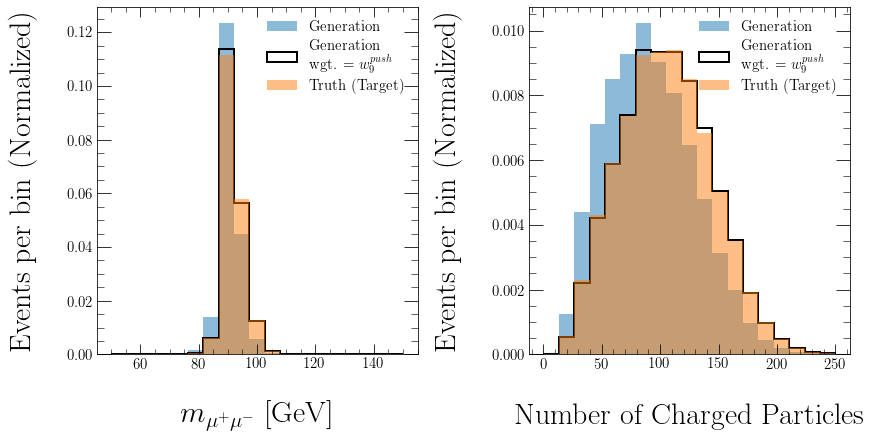

ITERATION: 10


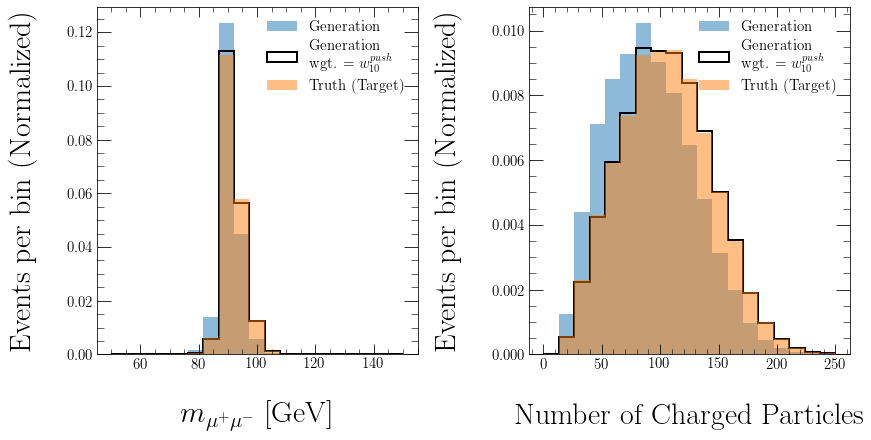

In [51]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(
        m_ll_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[0].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0].hist(m_ll_unknown_G,
               weights=weights_stress,
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(
        nTracks_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               weights=weights_stress,
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

# Stress Weights are Random
After standardizing each observable $x$ to $x'$, the weights are given by $w\sim  \mathcal{N}(0, \text{sigmoid}(x'))$.

## UniFold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles separately.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

### Setup Datasets

In [52]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S = train_test_split(Events_0.events['truth_m_ll'][mypass_0],
                                                                      Events_0.events['m_ll'][mypass_0], 
                                                                      test_size=0.5)
                                                                    
# m_ll_unknown_G = Events_unknown.events['truth_m_ll'][mypass_unknown]
# m_ll_unknown_S = Events_unknown.events['m_ll'][mypass_unknown]

In [53]:
scaler_m_ll = preprocessing.StandardScaler()

scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))

In [54]:
weights_m_ll_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_m_ll_seed
]
weights_m_ll_stress = np.array(weights_m_ll_stress)

weights_m_ll_stress = weights_m_ll_stress / np.mean(weights_m_ll_stress)

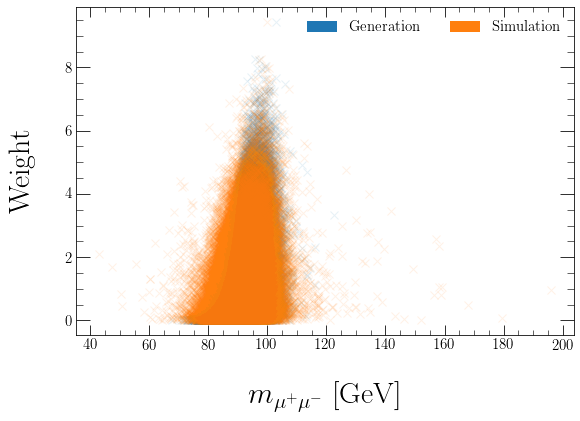

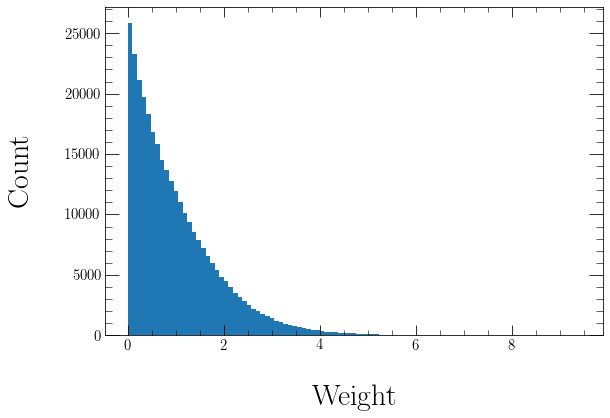

In [55]:
plt.figure()
plt.plot(m_ll_unknown_G, weights_m_ll_stress, 'x', alpha=0.1, label = 'Generation')
plt.plot(m_ll_unknown_S, weights_m_ll_stress, 'x', alpha=0.1, label = 'Simulation')
plt.xlabel('$m_{\mu^+\mu^-}$ [GeV]')
plt.ylabel('Weight')
handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
plt.legend(handles, labels, ncol=2)
plt.show()

plt.figure()
plt.hist(weights_m_ll_stress,
         bins=np.linspace(np.min(weights_m_ll_stress),
                          np.max(weights_m_ll_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

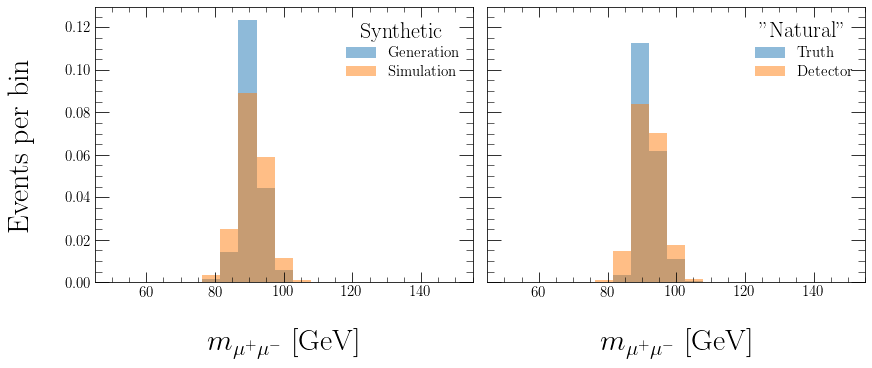

In [56]:
bins = np.linspace(50, 150, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(m_ll_0_G, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, 
                       label='Generation', 
                       **plot_style_2)
hS0, _, _ = ax[0].hist(m_ll_0_S, 
#                        weights=weightsMC_0[mypass_0], 
                       bins=bins, label='Simulation', 
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[1].hist(m_ll_unknown_G, 
                       weights=weights_m_ll_stress, 
                       bins=bins,
                       label='Truth', 
                       **plot_style_2)
hS1, _, _ = ax[1].hist(m_ll_unknown_S, 
                       weights=weights_m_ll_stress, 
                       bins=bins, 
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

In [57]:
nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(np.array(ntrack_0_Gen),
                                                                      np.array(ntrack_0_Sim), 
                                                                      test_size=0.5)

In [58]:
scaler_nTracks = preprocessing.StandardScaler()

scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

In [59]:
weights_nTracks_stress = [abs(np.random.normal(0, sigmoid(std))) for std in weight_nTracks_seed]
weights_nTracks_stress = np.array(weights_nTracks_stress)

weights_nTracks_stress = weights_nTracks_stress/np.mean(weights_nTracks_stress)

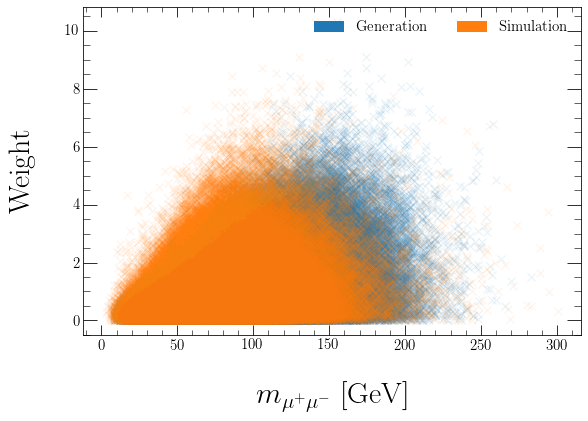

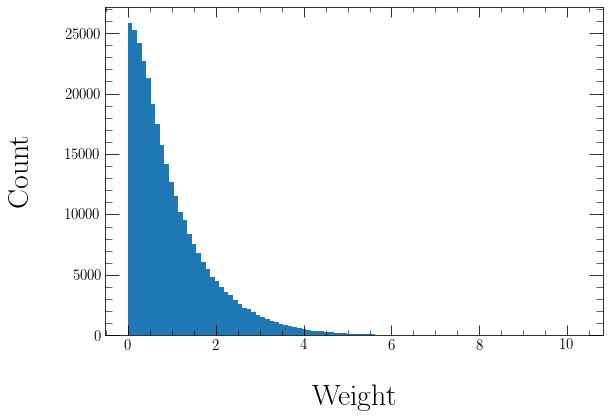

In [60]:
plt.figure()
plt.plot(nTracks_unknown_G, weights_nTracks_stress, 'x', alpha=0.1, label = 'Generation')
plt.plot(nTracks_unknown_S, weights_nTracks_stress, 'x', alpha=0.1, label = 'Simulation')
plt.xlabel('$m_{\mu^+\mu^-}$ [GeV]')
plt.ylabel('Weight')
handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
plt.legend(handles, labels, ncol=2)
plt.show()

plt.figure()
plt.hist(weights_nTracks_stress,
         bins=np.linspace(np.min(weights_nTracks_stress),
                          np.max(weights_nTracks_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

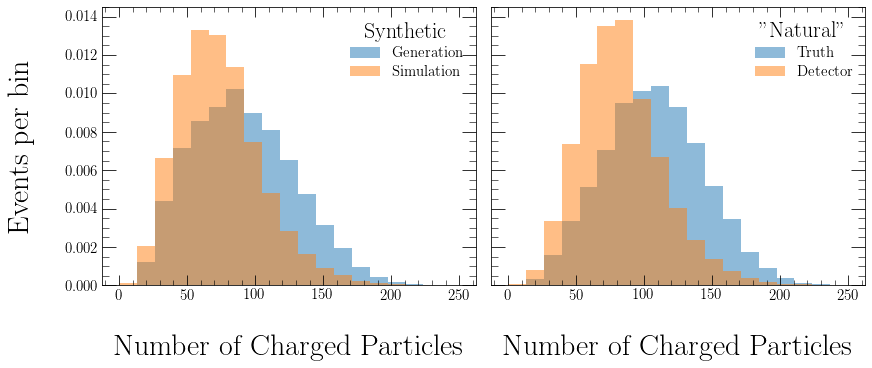

In [61]:
bins = np.linspace(0, 250, 20)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)
ax[0].set_xlabel('Number of Charged Particles')
ax[0].set_ylabel('Events per bin')
hG0, _, _ = ax[0].hist(nTracks_0_G,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Generation',
                       **plot_style_2)
hS0, _, _ = ax[0].hist(nTracks_0_S,
                       #weights=weightsMC_0[mypass_0],
                       bins=bins,
                       label='Simulation',
                       **plot_style_2)
legend = ax[0].legend(title='Synthetic', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1].hist(nTracks_unknown_G,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Truth',
                       **plot_style_2)
hS1, _, _ = ax[1].hist(nTracks_unknown_S,
                       weights=weights_nTracks_stress,
                       bins=bins,
                       label='Detector',
                       **plot_style_2)
legend = ax[1].legend(title='"Natural"', loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Unfold $m_{\mu^+\mu^-}$

In [62]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(m_ll_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(m_ll_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(m_ll_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(m_ll_unknown_S.reshape(-1,1)))

In [63]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_m_ll_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6855 - acc: 0.5010 - val_loss: 0.6825 - val_acc: 0.5022
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6844 - acc: 0.5014 - val_loss: 0.6824 - val_acc: 0.5019
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6843 - acc: 0.5010 - val_loss: 0.6824 - val_acc: 0.5023
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6843 - acc: 0.5011 - val_loss: 0.6824 - val_acc: 0.5022
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6843 - acc: 0.5010 - val_loss: 0.6824 - val_acc: 0.5015
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6843 - acc: 0.5012 - val_loss: 0.6823 - val_acc: 0.5013
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6843 - a

466582/466582 [==============================] - 1s 2us/step - loss: 0.6839 - acc: 0.5011 - val_loss: 0.6819 - val_acc: 0.5022
Epoch 60/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6839 - acc: 0.5011 - val_loss: 0.6819 - val_acc: 0.5025
Epoch 61/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6839 - acc: 0.5010 - val_loss: 0.6819 - val_acc: 0.5014
Restoring model weights from the end of the best epoch
Epoch 00061: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6870 - acc: 0.5006 - val_loss: 0.6874 - val_acc: 0.4982
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6869 - acc: 0.5006 - val_loss: 0.6875 - val_acc: 0.4984
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6869 - acc: 0.5004 - val_loss: 0.6875 - val_acc: 0.4985
Epoch 4/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6880 - acc: 0.5011 - val_loss: 0.6881 - val_acc: 0.5017
Restoring model weights from the end of the best epoch
Epoch 00043: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6818 - acc: 0.5000 - val_loss: 0.6813 - val_acc: 0.4998
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6815 - acc: 0.4998 - val_loss: 0.6813 - val_acc: 0.5000
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6815 - acc: 0.4998 - val_loss: 0.6813 - val_acc: 0.4996
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6815 - acc: 0.4997 - val_loss: 0.6814 - val_acc: 0.5001
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6816 - acc: 0.5001 - val_loss: 0.6813 - val_acc: 0.4994
Epoch 6/200
466582/466582 [=======

466582/466582 [==============================] - 1s 2us/step - loss: 0.6734 - acc: 0.4999 - val_loss: 0.6740 - val_acc: 0.4997
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6734 - acc: 0.5005 - val_loss: 0.6740 - val_acc: 0.4996
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6733 - acc: 0.5001 - val_loss: 0.6740 - val_acc: 0.4998
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6733 - acc: 0.5000 - val_loss: 0.6740 - val_acc: 0.4996
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6733 - acc: 0.5000 - val_loss: 0.6740 - val_acc: 0.4996
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6734 - acc: 0.4998 - val_loss: 0.6741 - val_acc: 0.5000
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6733 - acc: 0.5002 - val_loss: 0.6740 - val_acc: 0.4996
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 4s 8us/step - loss: 0.6950 - acc: 0.5016 - val_loss: 0.6913 - val_acc: 0.4987
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5007 - val_loss: 0.6912 - val_acc: 0.4997
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5012 - val_loss: 0.6912 - val_acc: 0.4995
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5015 - val_loss: 0.6912 - val_acc: 0.4989
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5015 - val_loss: 0.6912 - val_acc: 0.4996
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5018 - val_loss: 0.6913 - val_acc: 0.4998
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5009 - val_loss: 0.6912 - val_acc: 0.4992
Epoch 8/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5005 - val_loss: 0.6893 - val_acc: 0.4984
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5008 - val_loss: 0.6893 - val_acc: 0.5013
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5007 - val_loss: 0.6893 - val_acc: 0.5003
Epoch 22/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5005 - val_loss: 0.6893 - val_acc: 0.5009
Epoch 23/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5002 - val_loss: 0.6893 - val_acc: 0.5019
Epoch 24/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5014 - val_loss: 0.6893 - val_acc: 0.4996
Epoch 25/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6877 - acc: 0.5009 - val_loss: 0.6893 - val_acc: 0.5008
Epoch 26/200
466582/466582 [=====

466582/466582 [==============================] - 4s 9us/step - loss: 0.6772 - acc: 0.4996 - val_loss: 0.6717 - val_acc: 0.5002
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6718 - acc: 0.5001 - val_loss: 0.6715 - val_acc: 0.5003
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6718 - acc: 0.4999 - val_loss: 0.6716 - val_acc: 0.5003
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6718 - acc: 0.4998 - val_loss: 0.6716 - val_acc: 0.5005
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6718 - acc: 0.4998 - val_loss: 0.6716 - val_acc: 0.5005
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6717 - acc: 0.4999 - val_loss: 0.6716 - val_acc: 0.5003
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6718 - acc: 0.4999 - val_loss: 0.6716 - val_acc: 0.5005
Epoch 8/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6933 - acc: 0.5011 - val_loss: 0.6948 - val_acc: 0.5006
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6948 - val_acc: 0.4990
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6933 - acc: 0.5011 - val_loss: 0.6947 - val_acc: 0.5008
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 4s 9us/step - loss: 0.6773 - acc: 0.4998 - val_loss: 0.6714 - val_acc: 0.5001
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6716 - acc: 0.5000 - val_loss: 0.6713 - val_acc: 0.4991
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6716 - acc: 0.5003 - val_loss: 0.6713 - val_acc: 0.4997
Epoch 4/200
466582/466582 [=====

#### Step 1 Results (Simulation-level)

ITERATION 1:


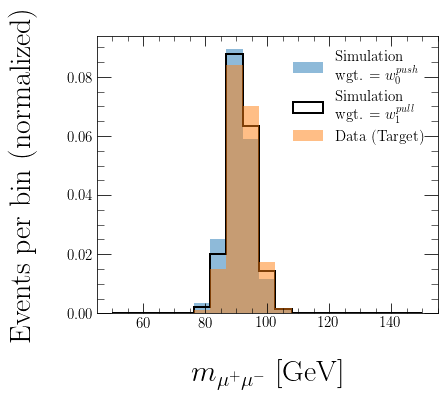

ITERATION 2:


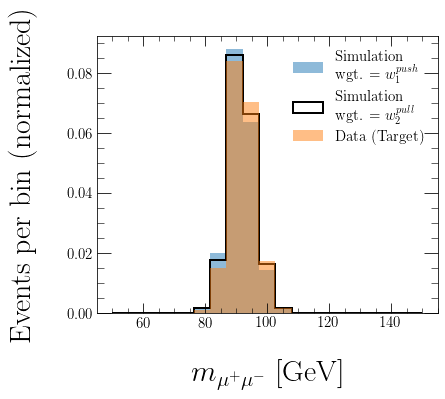

ITERATION 3:


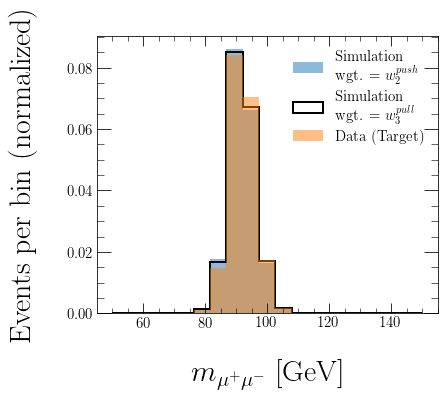

ITERATION 4:


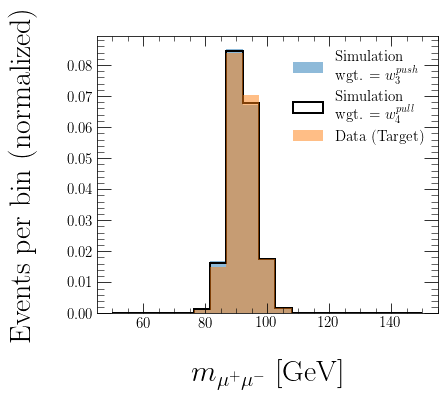

ITERATION 5:


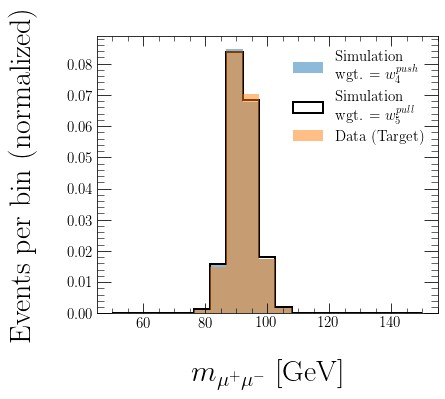

ITERATION 6:


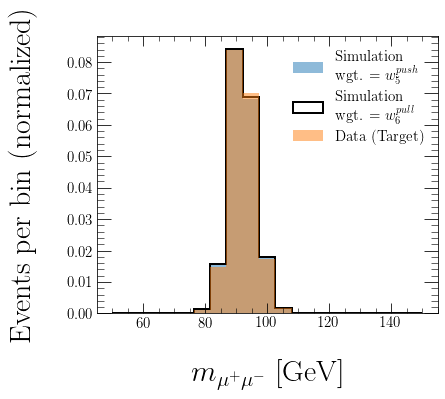

ITERATION 7:


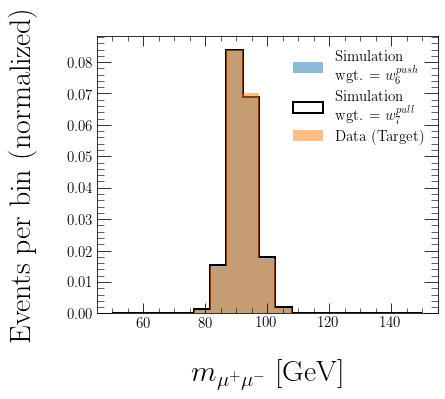

ITERATION 8:


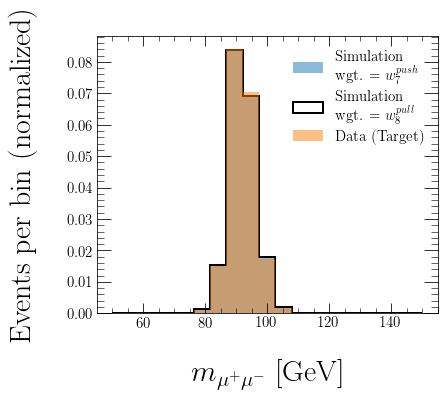

ITERATION 9:


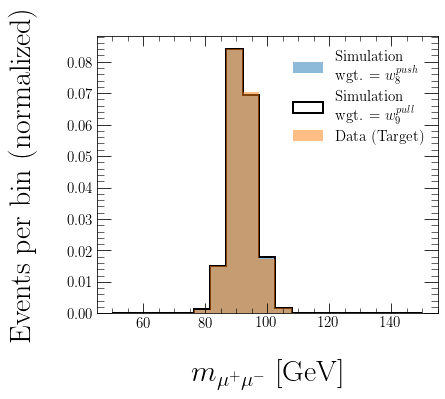

ITERATION 10:


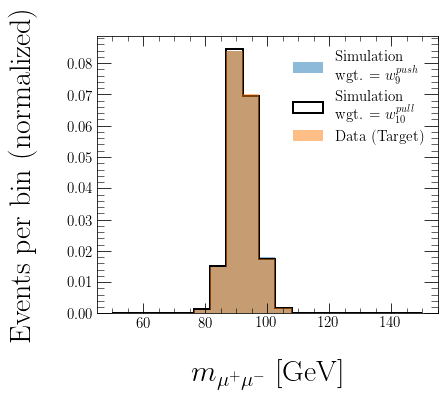

In [64]:
bins = np.linspace(50, 150, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(m_ll_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        m_ll_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_S,
        weights=weights_m_ll_stress,
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


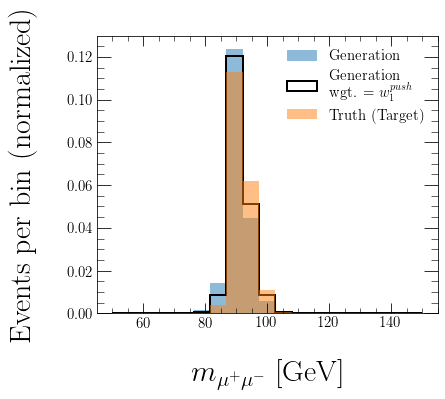

ITERATION 2:


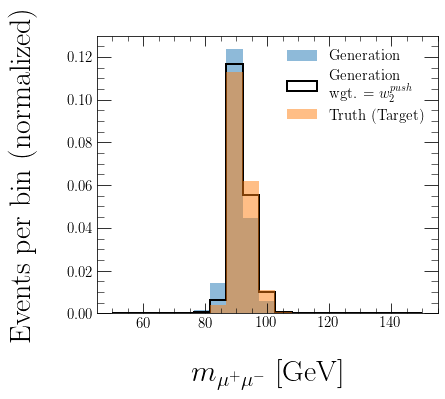

ITERATION 3:


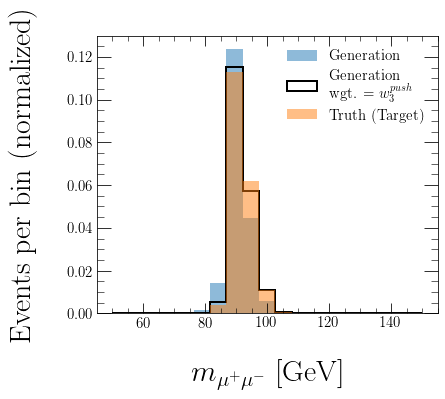

ITERATION 4:


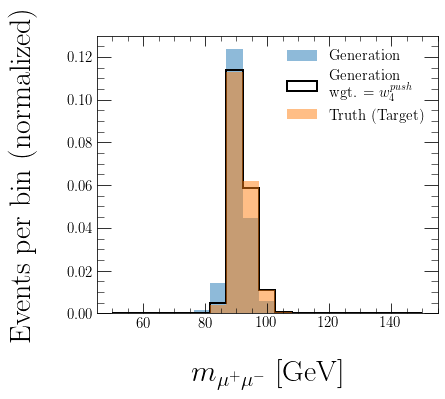

ITERATION 5:


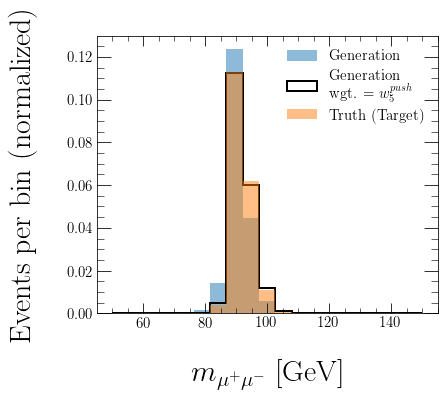

ITERATION 6:


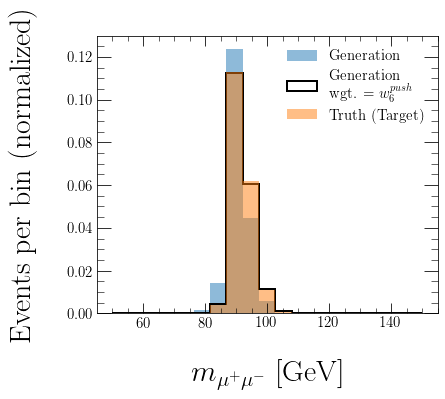

ITERATION 7:


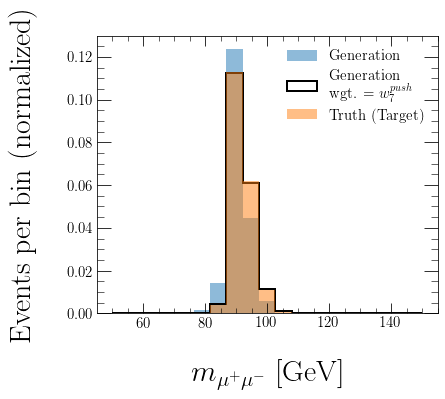

ITERATION 8:


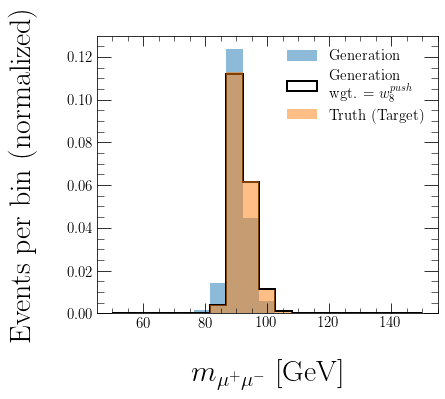

ITERATION 9:


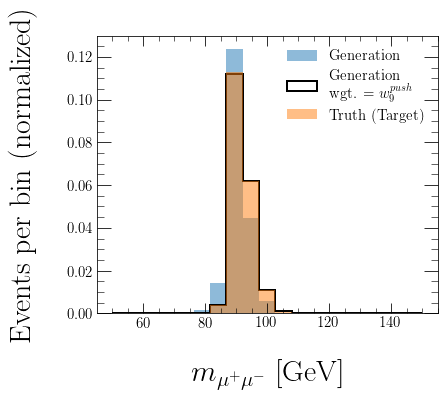

ITERATION 10:


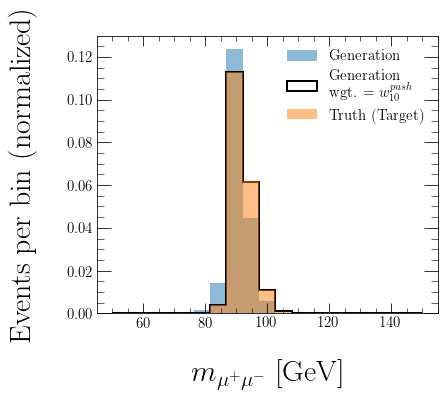

In [65]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        m_ll_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(m_ll_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        m_ll_unknown_G,
        weights=weights_m_ll_stress,
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$m_{\mu^+\mu^-}$ [GeV]")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold Number of Charged Particles

In [66]:
scaler_G = preprocessing.StandardScaler()
scaler_S = preprocessing.StandardScaler()

scaler_G.fit(nTracks_0_G.reshape(-1,1))
scaler_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = np.squeeze(scaler_G.transform(nTracks_0_G.reshape(-1,1)))
theta_0_S = np.squeeze(scaler_S.transform(nTracks_0_S.reshape(-1,1)))
theta_unknown_S = np.squeeze(scaler_S.transform(nTracks_unknown_S.reshape(-1,1)))

In [67]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = unifold(iterations=10,
                     theta_0_G=theta_0_G,
                     theta_0_S=theta_0_S,
#                      weightsMC_0=weightsMC_0[mypass_0],
                     theta_unknown_S=theta_unknown_S,
                     weightsMC_unknown=weights_nTracks_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 10us/step - loss: 0.6830 - acc: 0.5006 - val_loss: 0.6797 - val_acc: 0.5017
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6801 - acc: 0.4994 - val_loss: 0.6795 - val_acc: 0.5018
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6800 - acc: 0.4994 - val_loss: 0.6796 - val_acc: 0.5018
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6800 - acc: 0.4995 - val_loss: 0.6796 - val_acc: 0.5018
Epoch 5/200
466582/466582 [==============================] - 2s 4us/step - loss: 0.6799 - acc: 0.4997 - val_loss: 0.6796 - val_acc: 0.5017
Epoch 6/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6799 - acc: 0.4995 - val_loss: 0.6796 - val_acc: 0.5018
Epoch 7/200
466582/466582 [==============================] - 2s 3us/step - loss: 0.6799 - 

466582/466582 [==============================] - 2s 3us/step - loss: 0.6783 - acc: 0.5005 - val_loss: 0.6782 - val_acc: 0.4987
Epoch 10/200
466582/466582 [==============================] - 2s 3us/step - loss: 0.6783 - acc: 0.5005 - val_loss: 0.6782 - val_acc: 0.4988
Epoch 11/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6783 - acc: 0.5005 - val_loss: 0.6783 - val_acc: 0.4985
Epoch 12/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6783 - acc: 0.5004 - val_loss: 0.6782 - val_acc: 0.4988
Epoch 13/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6783 - acc: 0.5004 - val_loss: 0.6782 - val_acc: 0.4987
Epoch 14/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6783 - acc: 0.5003 - val_loss: 0.6782 - val_acc: 0.4987
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6783 - acc: 0.5003 - val_loss: 0.6783 - val_acc: 0.4985
Epoch 16/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6754 - acc: 0.5007 - val_loss: 0.6761 - val_acc: 0.4982
Epoch 29/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6754 - acc: 0.5006 - val_loss: 0.6762 - val_acc: 0.4982
Epoch 30/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6754 - acc: 0.5005 - val_loss: 0.6763 - val_acc: 0.4981
Epoch 31/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6754 - acc: 0.5004 - val_loss: 0.6761 - val_acc: 0.4982
Epoch 32/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6754 - acc: 0.5005 - val_loss: 0.6761 - val_acc: 0.4981
Restoring model weights from the end of the best epoch
Epoch 00032: early stopping

ITERATION: 4

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6954 - acc: 0.5006 - val_loss: 0.6960 - val_acc: 0.5021
Epoch 2/200
466

466582/466582 [==============================] - 1s 2us/step - loss: 0.6948 - acc: 0.5005 - val_loss: 0.6947 - val_acc: 0.5024
Epoch 24/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6948 - acc: 0.5009 - val_loss: 0.6947 - val_acc: 0.5026
Epoch 25/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6948 - acc: 0.5007 - val_loss: 0.6947 - val_acc: 0.5026
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.6719 - acc: 0.4998 - val_loss: 0.6655 - val_acc: 0.5002
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6652 - acc: 0.4998 - val_loss: 0.6651 - val_acc: 0.4999
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6651 - acc: 0.5000 - val_loss: 0.6651 - val_acc: 0.5002
Epoch 4/200
466582/466582 [====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6733 - acc: 0.5004 - val_loss: 0.6728 - val_acc: 0.4987
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 7

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 5s 11us/step - loss: 0.7012 - acc: 0.5007 - val_loss: 0.6968 - val_acc: 0.5010
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6973 - acc: 0.5011 - val_loss: 0.6968 - val_acc: 0.5010
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6973 - acc: 0.5001 - val_loss: 0.6968 - val_acc: 0.5008
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6972 - acc: 0.5005 - val_loss: 0.6967 - val_acc: 0.5024
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6972 - acc: 0.4998 - val_loss: 0.6968 - val_acc: 0.5012
Epoch 6/200
466582/

466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5007 - val_loss: 0.6898 - val_acc: 0.5031
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5003 - val_loss: 0.6898 - val_acc: 0.5024
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5006 - val_loss: 0.6898 - val_acc: 0.5026
Epoch 8/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6920 - acc: 0.4999 - val_loss: 0.6898 - val_acc: 0.5014
Epoch 9/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6920 - acc: 0.5001 - val_loss: 0.6898 - val_acc: 0.5014
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6920 - acc: 0.5006 - val_loss: 0.6898 - val_acc: 0.5022
Epoch 11/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6920 - acc: 0.5003 - val_loss: 0.6898 - val_acc: 0.5025
Epoch 12/200
466582/466582 [=========

466582/466582 [==============================] - 1s 3us/step - loss: 0.6691 - acc: 0.4995 - val_loss: 0.6675 - val_acc: 0.5014
Epoch 6/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6691 - acc: 0.4995 - val_loss: 0.6675 - val_acc: 0.5012
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6691 - acc: 0.4995 - val_loss: 0.6675 - val_acc: 0.5012
Epoch 8/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6691 - acc: 0.4996 - val_loss: 0.6675 - val_acc: 0.5014
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6691 - acc: 0.4995 - val_loss: 0.6675 - val_acc: 0.5012
Epoch 10/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6691 - acc: 0.4997 - val_loss: 0.6676 - val_acc: 0.5014
Epoch 11/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6691 - acc: 0.4996 - val_loss: 0.6675 - val_acc: 0.5014
Epoch 12/200
466582/466582 [=========

#### Step 1 Results (Simulation-level)

ITERATION 1:


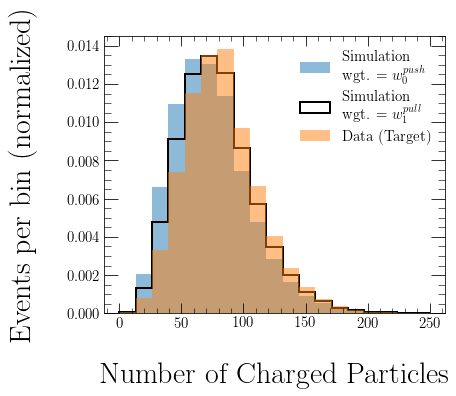

ITERATION 2:


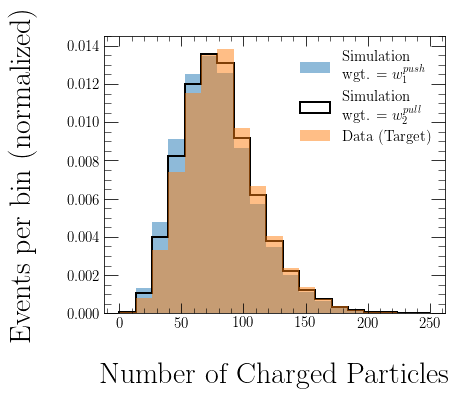

ITERATION 3:


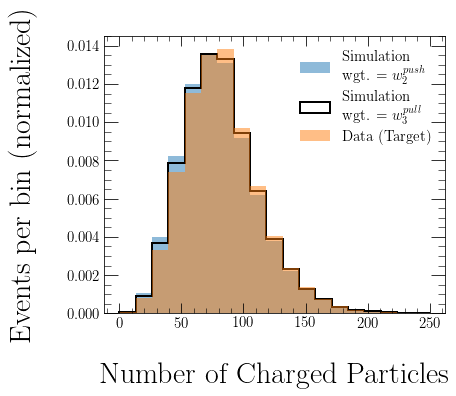

ITERATION 4:


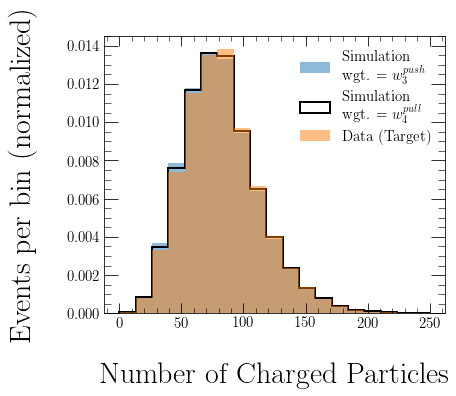

ITERATION 5:


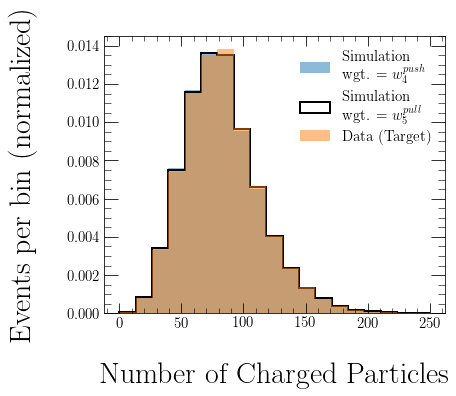

ITERATION 6:


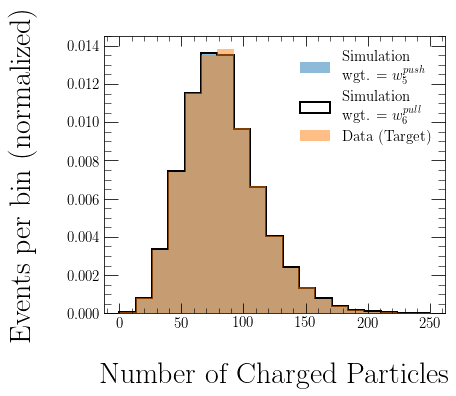

ITERATION 7:


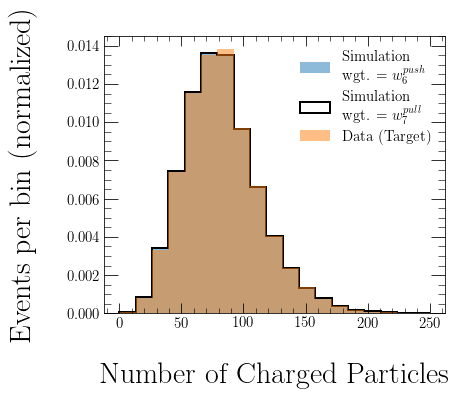

ITERATION 8:


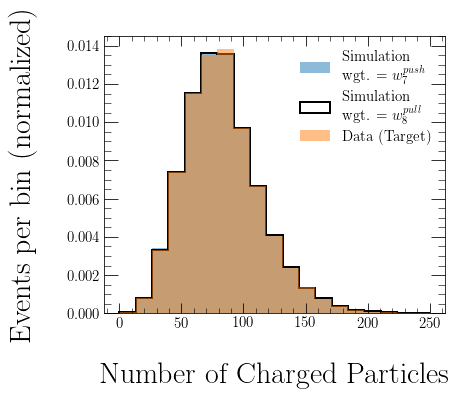

ITERATION 9:


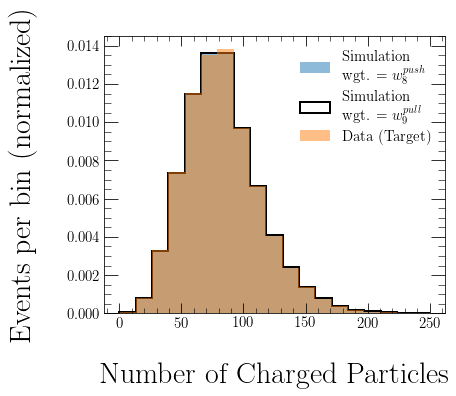

ITERATION 10:


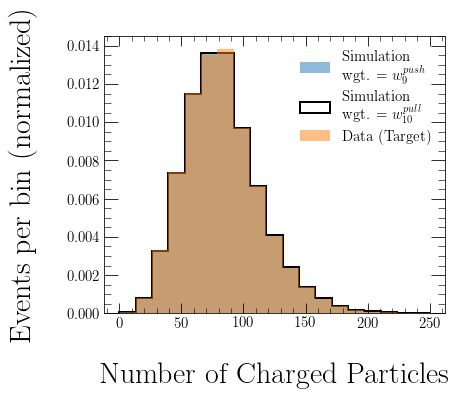

In [68]:
bins = np.linspace(0, 250, 20)

for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))

    if i == 0:
        weights_init = np.ones(len(nTracks_0_S))
    else:
        weights_init = weights[i - 1, 1, :]

    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_S,
        weights=weights_init,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) + '}'),
        **plot_style_2)

    hist1 = plt.hist(
        nTracks_0_S,
        weights=weights[i, 1, :],
        bins=bins,
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_S,
        weights=weights_nTracks_stress,
        bins=bins,
        label=r'Data (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION 1:


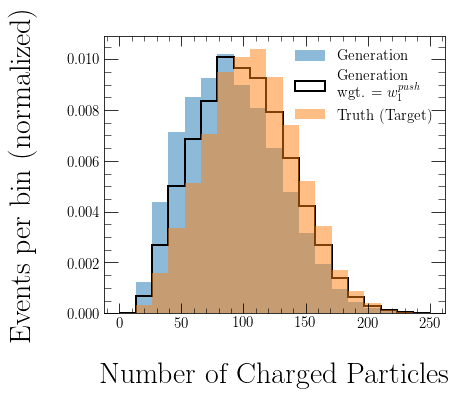

ITERATION 2:


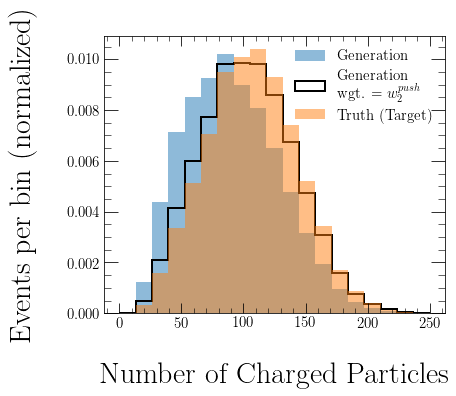

ITERATION 3:


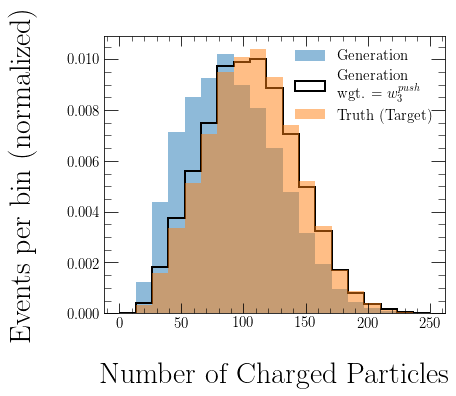

ITERATION 4:


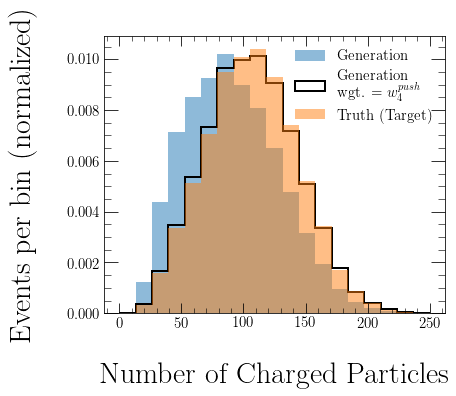

ITERATION 5:


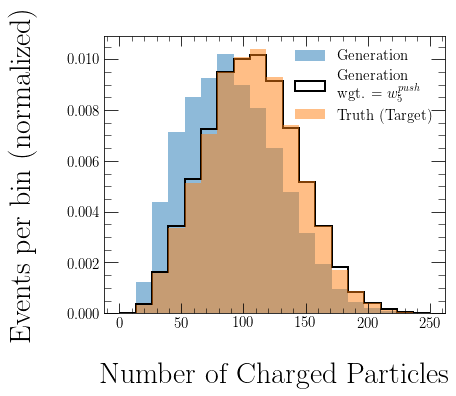

ITERATION 6:


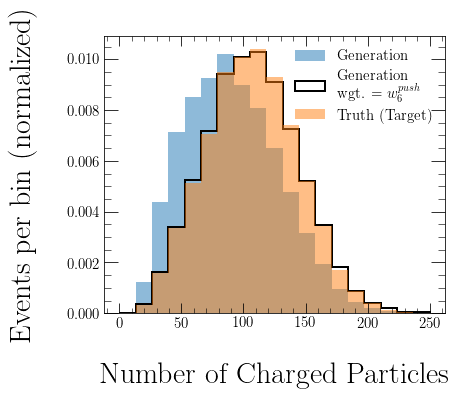

ITERATION 7:


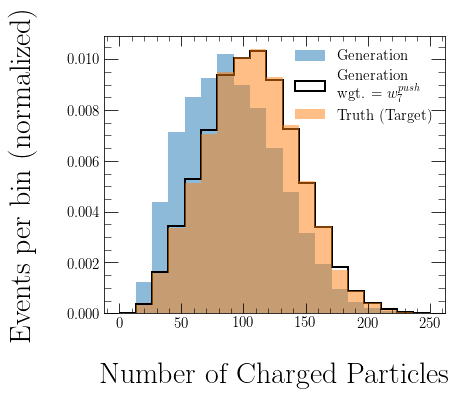

ITERATION 8:


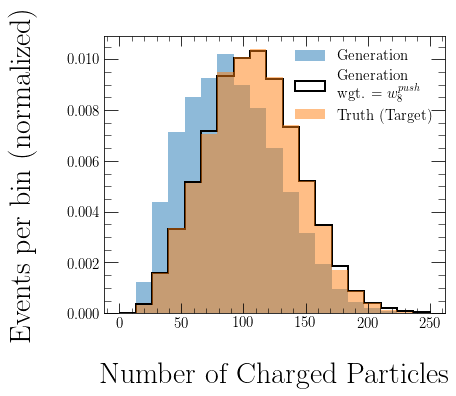

ITERATION 9:


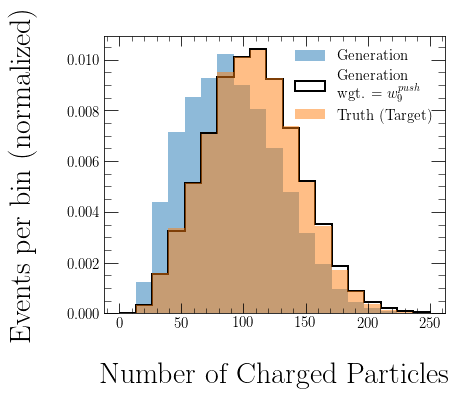

ITERATION 10:


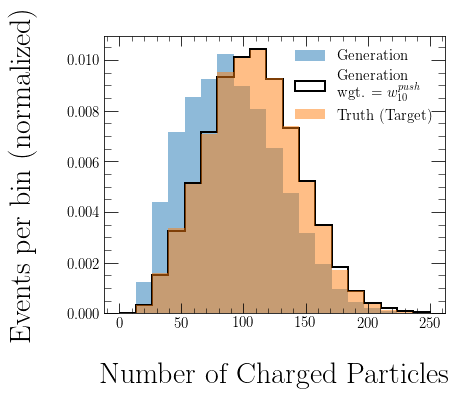

In [69]:
for i in range(len(weights)):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(
        nTracks_0_G,
        #                      weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)

    hist1 = plt.hist(nTracks_0_G,
                     weights=weights[i, 1, :],
                     bins=bins,
                     label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) + '}'),
                     **plot_style_1)
    hist2 = plt.hist(
        nTracks_unknown_G,
        weights=weights_nTracks_stress,
        bins=bins,
        label=r'Truth (Target)',
        **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"Number of Charged Particles")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

## Multifold

Unfold the distributions for $m_{\mu^+\mu^-}$ and the number of charged particles simultaneously.

*** As of this time, simulation with only one set of generator parameters is available. So, we will split this simulation in half, using one half as the synthetic dataset, and the other half as the unknown "natural" dataset.

In [70]:
K.clear_session()

### Setup datasets

In [71]:
m_ll_0_G, m_ll_unknown_G, m_ll_0_S, m_ll_unknown_S, nTracks_0_G, nTracks_unknown_G, nTracks_0_S, nTracks_unknown_S = train_test_split(
    Events_0.events['truth_m_ll'][mypass_0],
    Events_0.events['m_ll'][mypass_0],
    np.array(ntrack_0_Gen),
    np.array(ntrack_0_Sim),
    test_size=0.5)

In [72]:
scaler_m_ll = preprocessing.StandardScaler()
scaler_m_ll.fit(np.concatenate((m_ll_0_G, m_ll_unknown_G)).reshape(-1,1))

scaler_nTracks = preprocessing.StandardScaler()
scaler_nTracks.fit(np.concatenate((nTracks_0_G, nTracks_unknown_G)).reshape(-1,1))

weight_m_ll_seed = np.squeeze(scaler_m_ll.transform(m_ll_unknown_G.reshape(-1,1)))
weight_nTracks_seed = np.squeeze(scaler_nTracks.transform(nTracks_unknown_G.reshape(-1,1)))

weight_seed = weight_m_ll_seed + weight_nTracks_seed

In [73]:
weights_stress = [
    abs(np.random.normal(0, sigmoid(std))) for std in weight_seed
]
weights_stress = np.array(weights_stress)

weights_stress = weights_stress / np.mean(weights_stress)

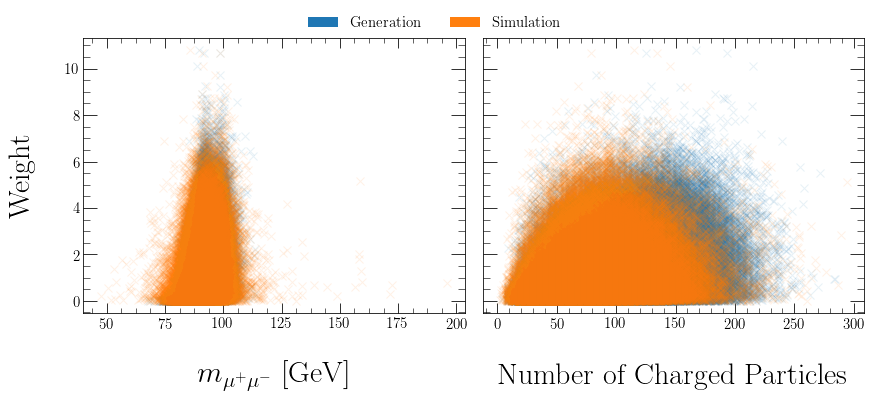

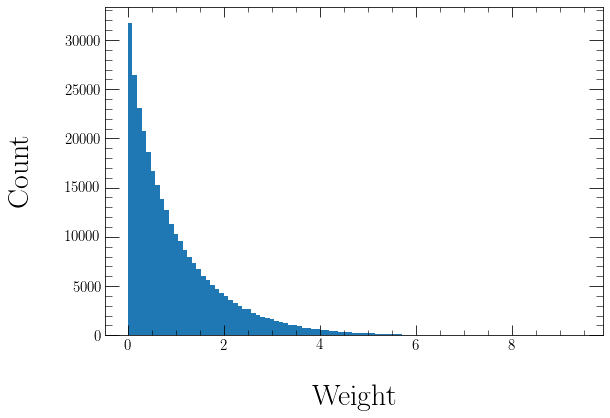

In [74]:
fig, ax = plt.subplots(1,2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey='row')

ax[0].plot(m_ll_unknown_G, weights_stress, 'x', alpha=0.1, label = 'Generation')
ax[0].plot(m_ll_unknown_S, weights_stress, 'x', alpha=0.1, label = 'Simulation')
ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0].set_ylabel('Weight')

ax[1].plot(nTracks_unknown_G, weights_stress, 'x', alpha=0.1, label = 'Generation')
ax[1].plot(nTracks_unknown_S, weights_stress, 'x', alpha=0.1, label = 'Simulation')
ax[1].set_xlabel('Number of Charged Particles')

handles = [Patch(facecolor='C0'), Patch(facecolor='C1')]
labels = ['Generation', 'Simulation']
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.665, 1.1))
fig.show()

plt.figure()
plt.hist(weights_stress,
         bins=np.linspace(np.min(weights_m_ll_stress),
                          np.max(weights_m_ll_stress), 100))
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

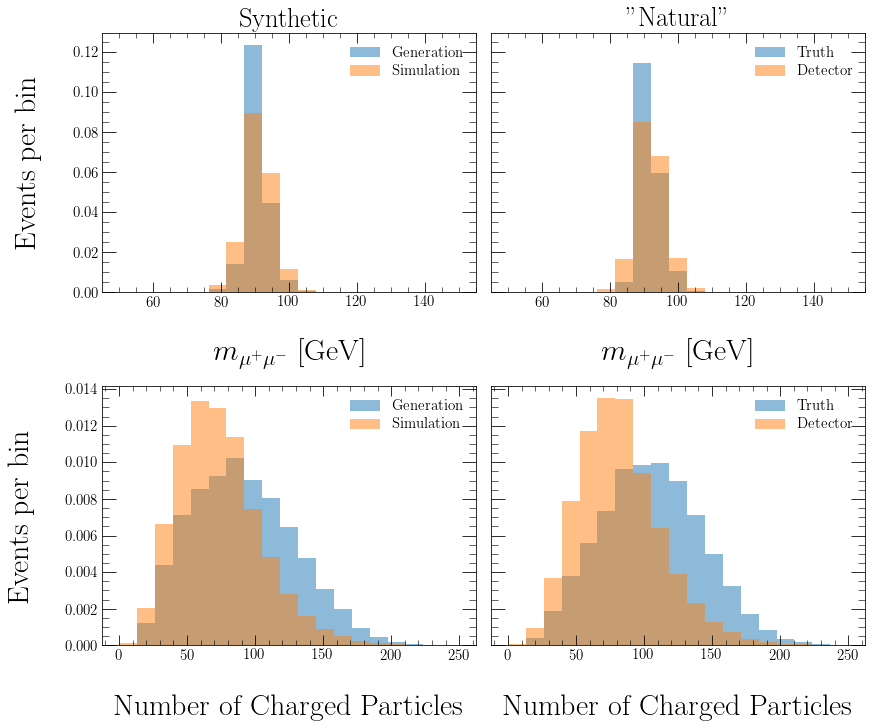

In [75]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(50, 150, 20)

ax[0, 0].set_title('Synthetic')
ax[0, 0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(
    m_ll_0_G,
    #                           weights=weightsMC_0[mypass_0],
    bins=bins,
    label='Generation',
    **plot_style_2)
hS0, _, _ = ax[0, 0].hist(
    m_ll_0_S,
    #                           weights=weightsMC_0[mypass_0],
    bins=bins,
    label='Simulation',
    **plot_style_2)
legend = ax[0, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"')
ax[0, 1].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
hG1, _, _ = ax[0, 1].hist(m_ll_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[0, 1].hist(m_ll_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[0, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

bins = np.linspace(0, 250, 20)

ax[1, 0].set_xlabel('Number of Charged Particles')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(
    nTracks_0_G,
    #                           weights=weightsMC_0[mypass_0],
    bins=bins,
    label='Generation',
    **plot_style_2)
hS0, _, _ = ax[1, 0].hist(
    nTracks_0_S,
    #                           weights=weightsMC_0[mypass_0],
    bins=bins,
    label='Simulation',
    **plot_style_2)
legend = ax[1, 0].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Number of Charged Particles')
hG1, _, _ = ax[1, 1].hist(nTracks_unknown_G,
                          weights=weights_stress,
                          bins=bins,
                          label='Truth',
                          **plot_style_2)
hS1, _, _ = ax[1, 1].hist(nTracks_unknown_S,
                          weights=weights_stress,
                          bins=bins,
                          label='Detector',
                          **plot_style_2)
legend = ax[1, 1].legend(loc='upper right', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

### Unfold $m_{\mu^+\mu^-}$ and Number of Charged Particles Simultaneously

In [76]:
num_observables = 2

scaler_m_ll_G = preprocessing.StandardScaler()
scaler_m_ll_S = preprocessing.StandardScaler()

scaler_m_ll_G.fit(m_ll_0_G.reshape(-1,1))
scaler_m_ll_S.fit(np.concatenate((m_ll_0_S, m_ll_unknown_S)).reshape(-1,1))

scaler_nTracks_G = preprocessing.StandardScaler()
scaler_nTracks_S = preprocessing.StandardScaler()

scaler_nTracks_G.fit(nTracks_0_G.reshape(-1,1))
scaler_nTracks_S.fit(np.concatenate((nTracks_0_S, nTracks_unknown_S)).reshape(-1,1))

theta_0_G = (np.squeeze(scaler_m_ll_G.transform(m_ll_0_G.reshape(-1,1))),
             np.squeeze(scaler_nTracks_G.transform(nTracks_0_G.reshape(-1,1))))

theta_0_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_0_S.reshape(-1,1))),
             np.squeeze(scaler_nTracks_S.transform(nTracks_0_S.reshape(-1,1))))

theta_unknown_S = (np.squeeze(scaler_m_ll_S.transform(m_ll_unknown_S.reshape(-1,1))),
                   np.squeeze(scaler_nTracks_S.transform(nTracks_unknown_S.reshape(-1,1))))

In [77]:
# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=10,
                       theta_0_G=theta_0_G,
                       theta_0_S=theta_0_S,
#                        weightsMC_0=weightsMC_0[mypass_0],
                       theta_unknown_S=theta_unknown_S,
                       weightsMC_unknown=weights_stress)


ITERATION: 1

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6793 - acc: 0.4999 - val_loss: 0.6745 - val_acc: 0.5026
Epoch 2/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6752 - acc: 0.4996 - val_loss: 0.6743 - val_acc: 0.5023
Epoch 3/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6751 - acc: 0.4997 - val_loss: 0.6743 - val_acc: 0.5022
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6751 - acc: 0.4997 - val_loss: 0.6743 - val_acc: 0.5023
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6750 - acc: 0.4998 - val_loss: 0.6742 - val_acc: 0.5018
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6749 - acc: 0.4999 - val_loss: 0.6743 - val_acc: 0.5024
Epoch 7/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6749 - a

466582/466582 [==============================] - 1s 3us/step - loss: 0.6842 - acc: 0.4995 - val_loss: 0.6849 - val_acc: 0.5000
Epoch 3/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6841 - acc: 0.4997 - val_loss: 0.6849 - val_acc: 0.5000
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6842 - acc: 0.5002 - val_loss: 0.6849 - val_acc: 0.5001
Epoch 5/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6842 - acc: 0.4998 - val_loss: 0.6849 - val_acc: 0.5002
Epoch 6/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6841 - acc: 0.5001 - val_loss: 0.6849 - val_acc: 0.5002
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6841 - acc: 0.5001 - val_loss: 0.6849 - val_acc: 0.4999
Epoch 8/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6842 - acc: 0.4998 - val_loss: 0.6849 - val_acc: 0.4999
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6949 - acc: 0.5001 - val_loss: 0.6961 - val_acc: 0.5024
Epoch 20/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6949 - acc: 0.4999 - val_loss: 0.6962 - val_acc: 0.5007
Epoch 21/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6949 - acc: 0.5000 - val_loss: 0.6962 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping

STEP 2

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 2s 5us/step - loss: 0.6711 - acc: 0.5001 - val_loss: 0.6681 - val_acc: 0.4995
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6679 - acc: 0.5002 - val_loss: 0.6680 - val_acc: 0.4995
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6679 - acc: 0.5002 - val_loss: 0.6680 - val_acc: 0.4992
Epoch 4/200
466582/466582 [=====

466582/466582 [==============================] - 1s 3us/step - loss: 0.6903 - acc: 0.5005 - val_loss: 0.6904 - val_acc: 0.4994
Epoch 15/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6903 - acc: 0.5009 - val_loss: 0.6904 - val_acc: 0.5002
Epoch 16/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6902 - acc: 0.5011 - val_loss: 0.6904 - val_acc: 0.4993
Epoch 17/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6902 - acc: 0.5006 - val_loss: 0.6903 - val_acc: 0.4995
Epoch 18/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6902 - acc: 0.5008 - val_loss: 0.6904 - val_acc: 0.4990
Epoch 19/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6902 - acc: 0.5003 - val_loss: 0.6904 - val_acc: 0.4999
Epoch 20/200
466582/466582 [==============================] - 1s 3us/step - loss: 0.6902 - acc: 0.5016 - val_loss: 0.6904 - val_acc: 0.5002
Epoch 21/200
466582/466582 [=====

466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.5006 - val_loss: 0.6924 - val_acc: 0.5005
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5014 - val_loss: 0.6924 - val_acc: 0.5009
Epoch 4/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5018 - val_loss: 0.6924 - val_acc: 0.5018
Epoch 5/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5010 - val_loss: 0.6924 - val_acc: 0.5012
Epoch 6/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5013 - val_loss: 0.6924 - val_acc: 0.4999
Epoch 7/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5017 - val_loss: 0.6924 - val_acc: 0.5016
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6924 - acc: 0.5010 - val_loss: 0.6924 - val_acc: 0.5010
Epoch 9/200
466582/466582 [============

466582/466582 [==============================] - 1s 2us/step - loss: 0.6550 - acc: 0.4999 - val_loss: 0.6541 - val_acc: 0.5004
Epoch 15/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6550 - acc: 0.4995 - val_loss: 0.6541 - val_acc: 0.5007
Epoch 16/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6550 - acc: 0.4997 - val_loss: 0.6541 - val_acc: 0.5005
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping

ITERATION: 9

STEP 1

Train on 466582 samples, validate on 155528 samples
Epoch 1/200
466582/466582 [==============================] - 3s 7us/step - loss: 0.6991 - acc: 0.5008 - val_loss: 0.6886 - val_acc: 0.4999
Epoch 2/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6926 - acc: 0.5009 - val_loss: 0.6886 - val_acc: 0.4997
Epoch 3/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6925 - acc: 0.5015 - val_loss: 0.6885 - val_acc: 0.4989
Epoch 4/200
466582

466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5002 - val_loss: 0.6533 - val_acc: 0.4994
Epoch 8/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5005 - val_loss: 0.6533 - val_acc: 0.4993
Epoch 9/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5003 - val_loss: 0.6533 - val_acc: 0.4991
Epoch 10/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5003 - val_loss: 0.6533 - val_acc: 0.4992
Epoch 11/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5002 - val_loss: 0.6533 - val_acc: 0.4990
Epoch 12/200
466582/466582 [==============================] - 1s 2us/step - loss: 0.6525 - acc: 0.5003 - val_loss: 0.6533 - val_acc: 0.4991
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping


#### Step 1 Results (Simulation-level)

ITERATION: 1


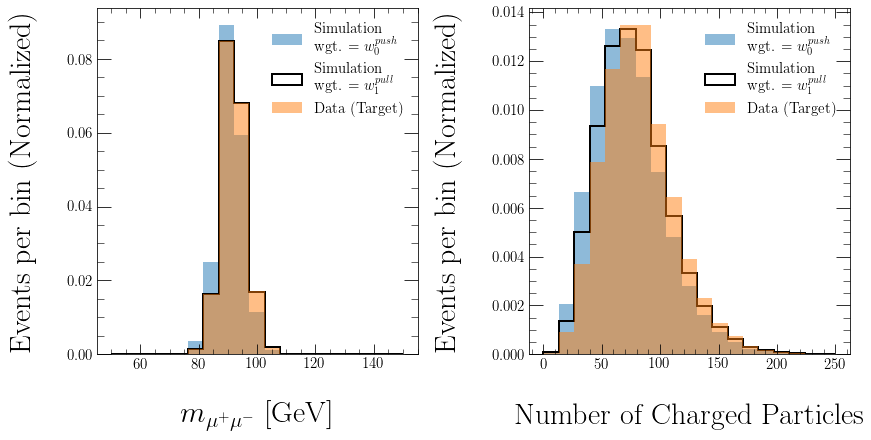

ITERATION: 2


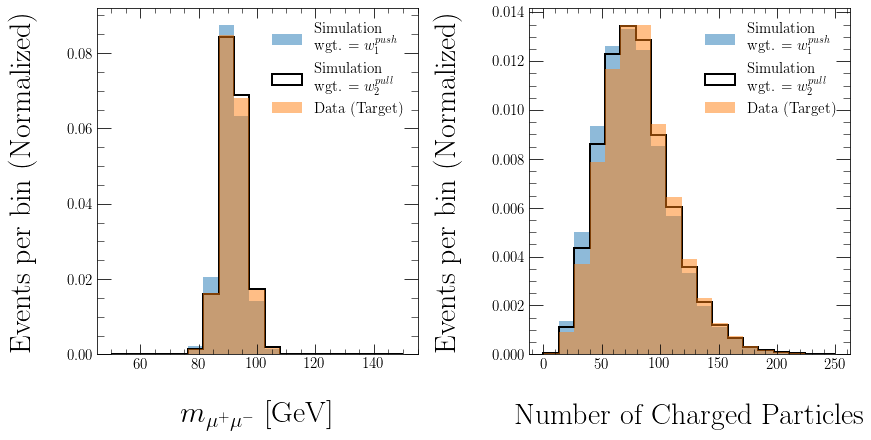

ITERATION: 3


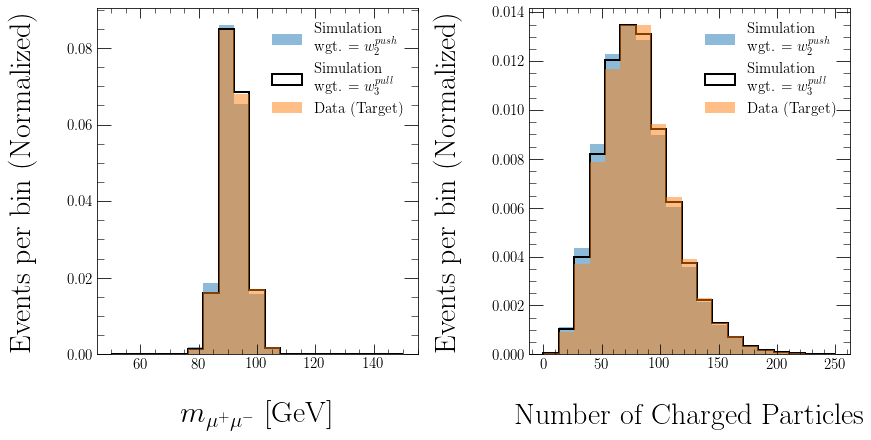

ITERATION: 4


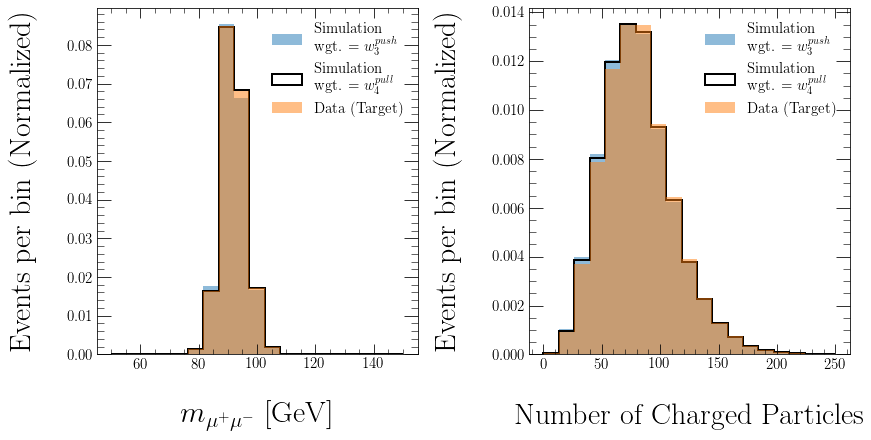

ITERATION: 5


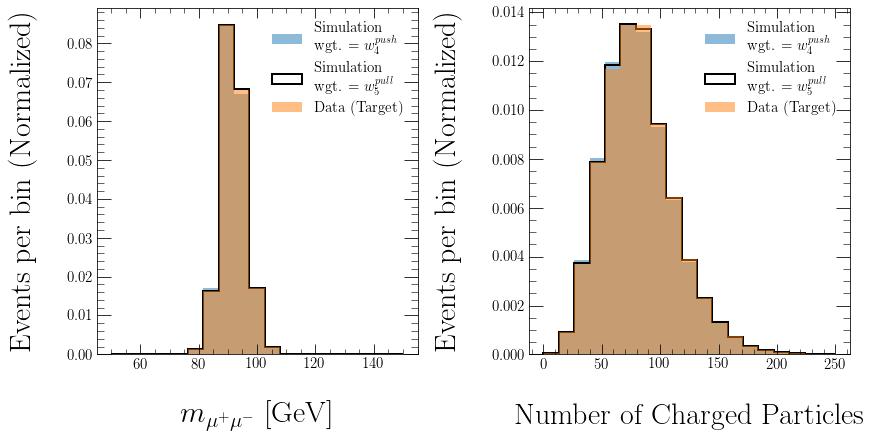

ITERATION: 6


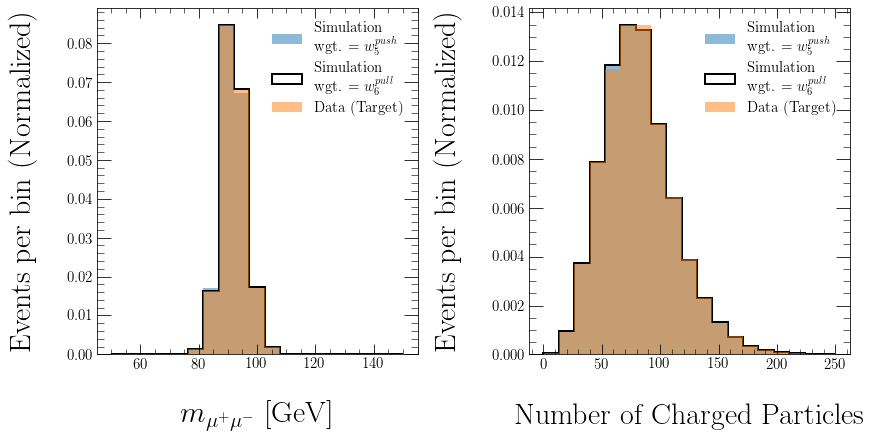

ITERATION: 7


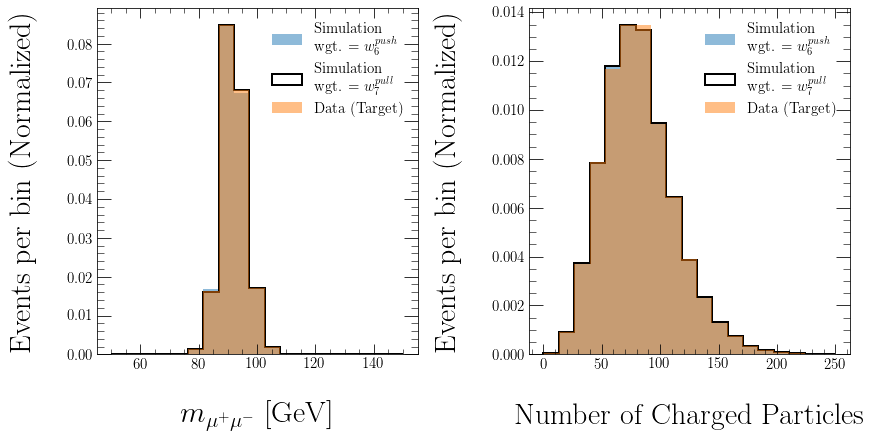

ITERATION: 8


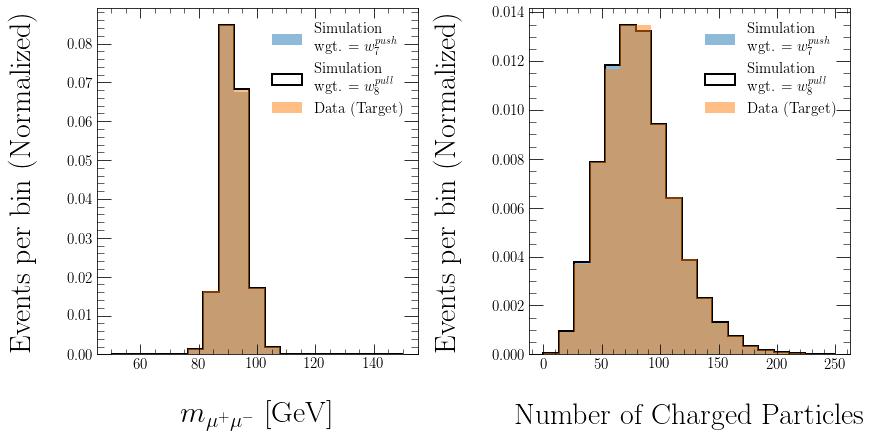

ITERATION: 9


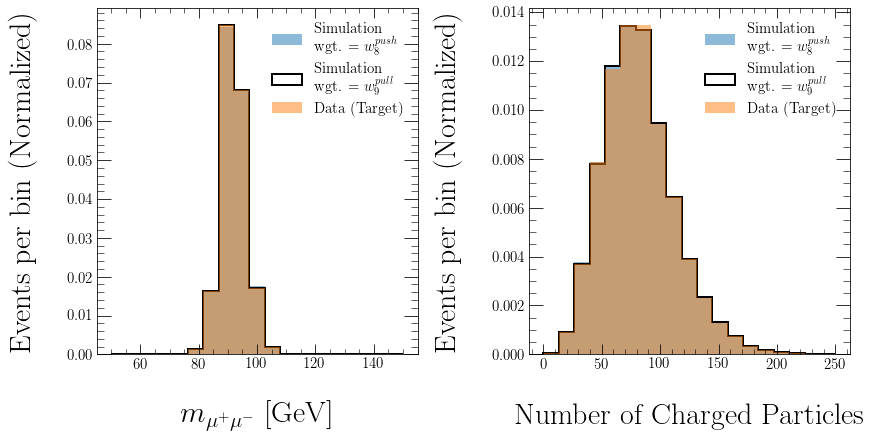

ITERATION: 10


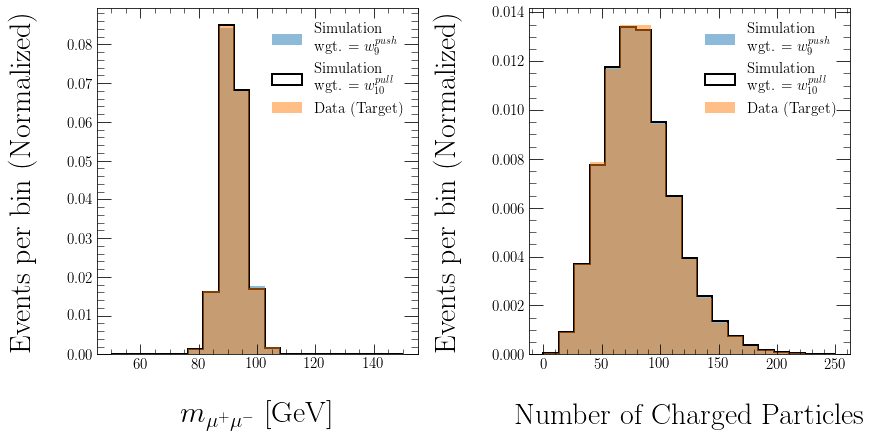

In [78]:
for i in range(len(weights)):

    if i == 0:
        weights_init = np.ones(len(weights[i - 1, 1, :]))
    else:
        weights_init = weights[i - 1, 1, :]

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(m_ll_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2)
    ax[0].hist(
        m_ll_0_S,
        bins=bins,
        weights=weights[i, 0, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0].hist(m_ll_unknown_S,
               weights=weights_stress,
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(nTracks_0_S,
               weights=weights_init,
               bins=bins,
               label='Simulation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i) +
                                                                 '}'),
               **plot_style_2)
    ax[1].hist(
        nTracks_0_S,
        bins=bins,
        weights=weights[i, 1, :],
        label='Simulation\nwgt. = $w_{}^{{pull}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1].hist(nTracks_unknown_S,
               weights=weights_stress,
               bins=bins,
               label=r'Data (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

#### Step 2 Results (Generation-level)

ITERATION: 1


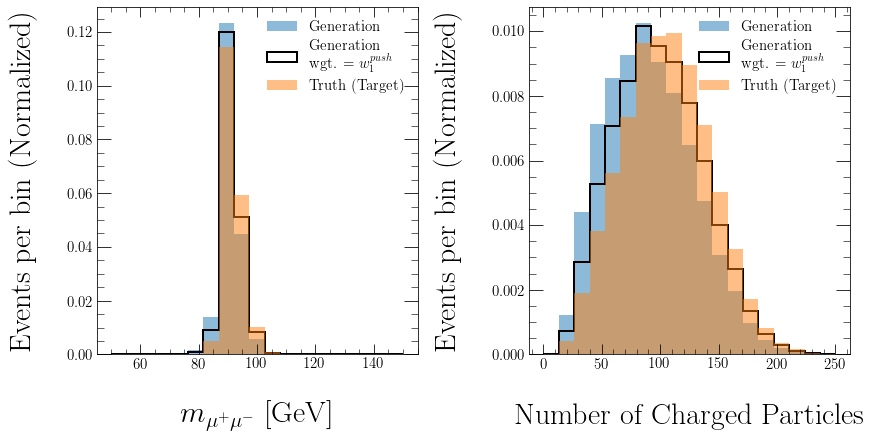

ITERATION: 2


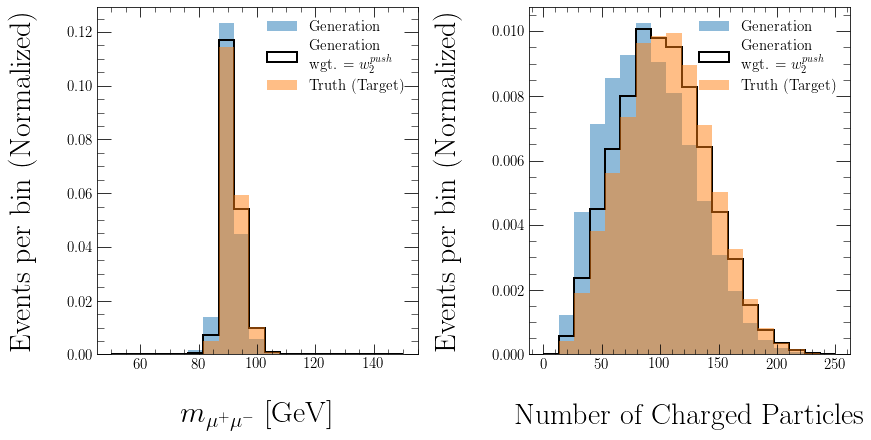

ITERATION: 3


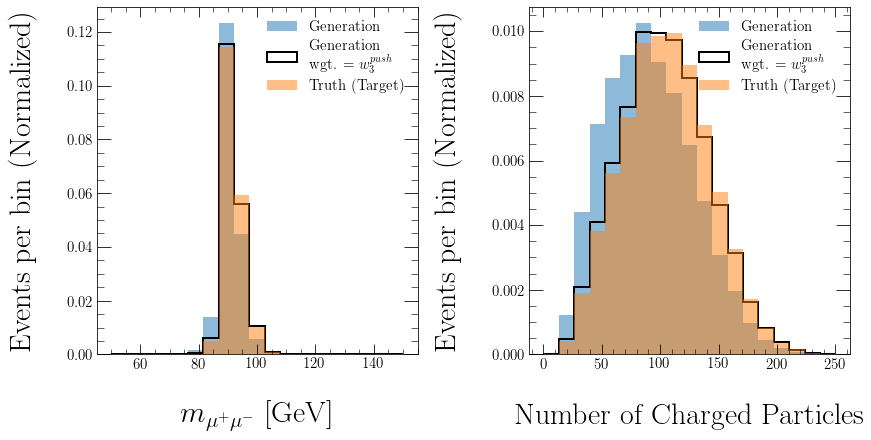

ITERATION: 4


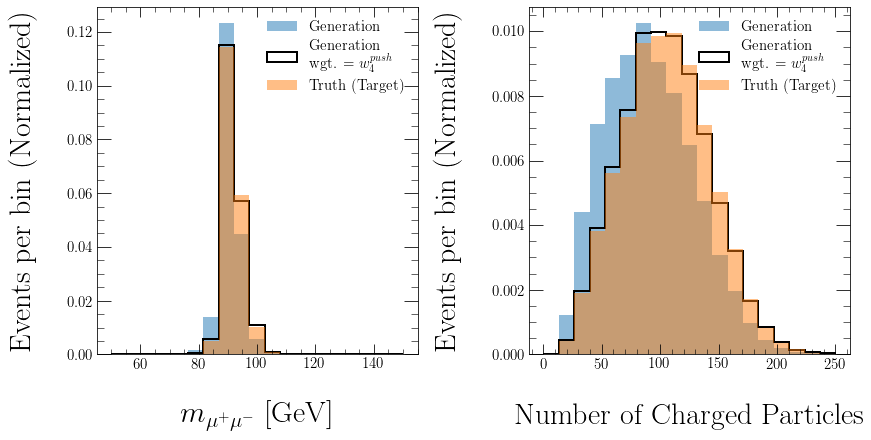

ITERATION: 5


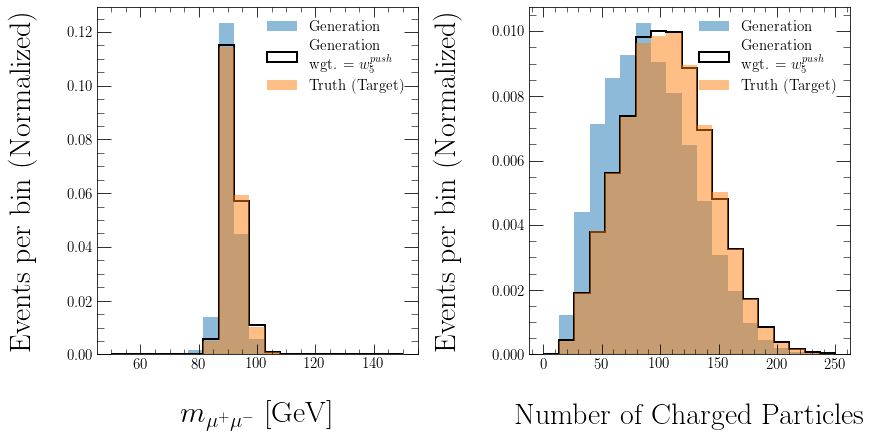

ITERATION: 6


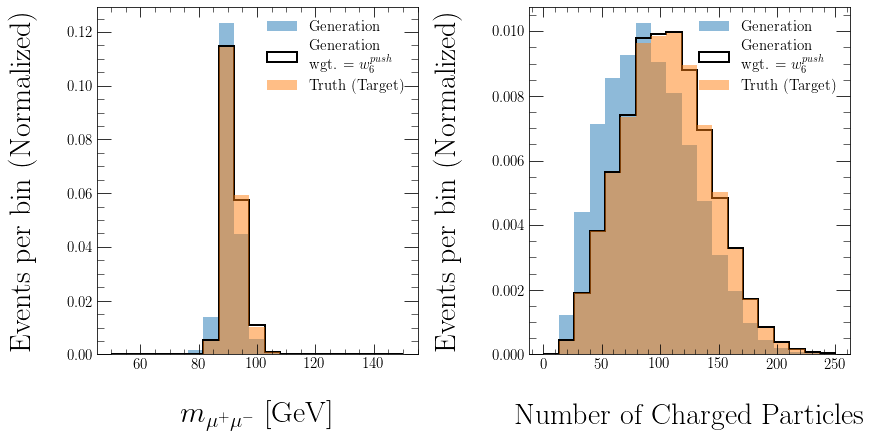

ITERATION: 7


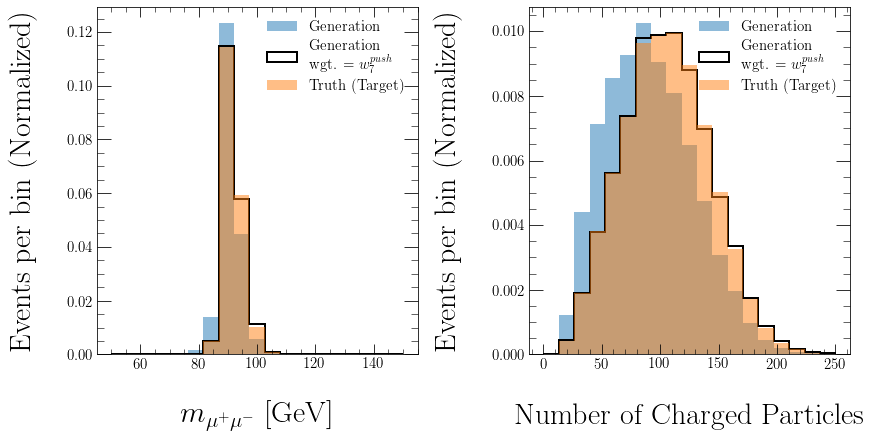

ITERATION: 8


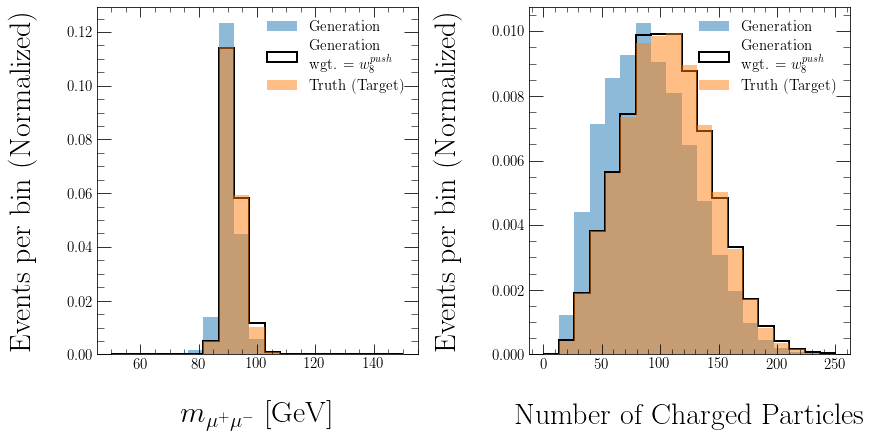

ITERATION: 9


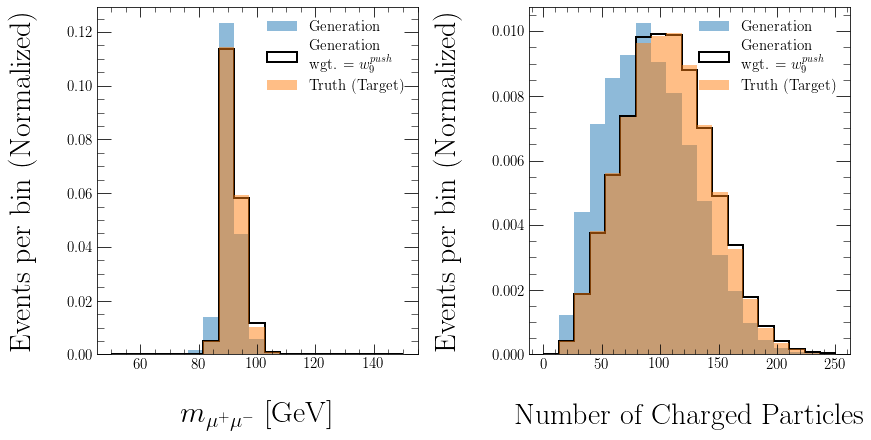

ITERATION: 10


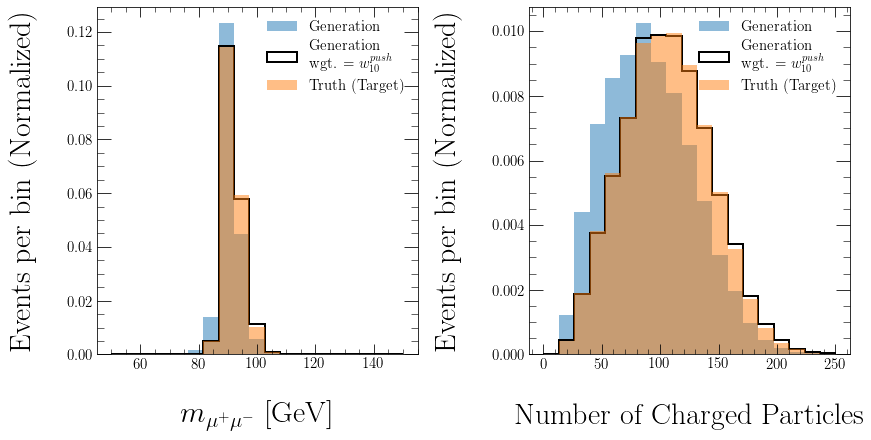

In [80]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(50, 150, 20)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel('$m_{\mu^+\mu^-}$ [GeV]')
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(
        m_ll_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[0].hist(
        m_ll_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)

    ax[0].hist(m_ll_unknown_G,
               weights=weights_stress,
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(0, 250, 20)

    ax[1].set_xlabel('Number of Charged Particles')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(
        nTracks_0_G,
        #                weights=weightsMC_0[mypass_0],
        bins=bins,
        label=r'Generation',
        **plot_style_2)
    ax[1].hist(
        nTracks_0_G,
        bins=bins,
        weights=weights[i, 1, :],
        label='Generation\nwgt. = $w_{}^{{push}}$'.format('{' + str(i + 1) +
                                                          '}'),
        **plot_style_1)
    ax[1].hist(nTracks_unknown_G,
               weights=weights_stress,
               bins=bins,
               label=r'Truth (Target)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()